# 0.0 Configuration and Data Loading

## 0.1 Imports

In [5]:
import pandas as pd
import math
import inflection
import numpy as np
import seaborn as sns
import datetime
from tabulate import tabulate
import pickle
import warnings
import random

from scipy                             import stats as ss
from matplotlib                        import pyplot as plt
from matplotlib.gridspec               import GridSpec
from IPython.display                   import Image
from IPython.core.display              import HTML
from boruta                            import BorutaPy
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing             import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble                  import RandomForestRegressor

## 0.2 Helper Functions

In [6]:
def jupyter_settings():
    
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [7]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        #training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )


    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std(mae_list),2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std(mape_list),2 ).astype( str ),
                          'RMSE': np.round( np.mean( rmse_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std(rmse_list),2 ).astype( str )}, index=[0] )    


In [8]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    v = np.sqrt(chi2corr/n / (min(kcorr-1, rcorr-1)))

    return v

In [9]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y-yhat ) / y ) 

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y-yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [10]:
jupyter_settings()

## 0.3 Loading Data

In [11]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False )

df_raw = pd.merge(df_sales_raw, df_store_raw, 'left', 'Store')

# 1.0 Data Description

## 1.1 Rename Columns

In [12]:
df1 = df_raw.copy()

In [13]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

new_cols = list( map( snakecase, old_cols ) )

In [15]:
df1.columns = new_cols

In [16]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimentions

In [17]:
print( 'Name of rows: {}'.format( df1.shape[0] ) )
print( 'Name of cols: {}'.format( df1.shape[1] ) )

Name of rows: 1017209
Name of cols: 18


## 1.3 Data Types

In [18]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

Quando não há informação de competidor mais próximo (NA), considerei a distância como 200000 (quase 3x o valor da distância do competidor mais longe).

In [20]:
df1['competition_distance'].max()

75860.0

In [21]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

Quando não há informação sobre:
   - há quantos meses há um competidor mais próximo
   - há quantos anos há um competidor mais próximo
   - a semana do ano em que a loja começou a participar da promoção 'promo2'
   - o ano em que a loja começou a participar da promoção 'promo2'

substituí pela informação baseada na data de atualização da base.

In [22]:
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

In [23]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

In [24]:
month_map = { 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [25]:
df1.sample(5).T

,322436,818558,341467,355290,401436
store,43,934,440,207,592
day_of_week,2,5,3,2,2
date,2014-09-30 00:00:00,2013-06-28 00:00:00,2014-09-10 00:00:00,2014-08-26 00:00:00,2014-07-08 00:00:00
sales,10856,8155,4410,8154,2780
customers,820,778,560,1198,372
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,1
store_type,d,a,d,a,a


In [26]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [28]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [29]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical


In [30]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [31]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


###  1.7.2 Categorical Attributes


In [32]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

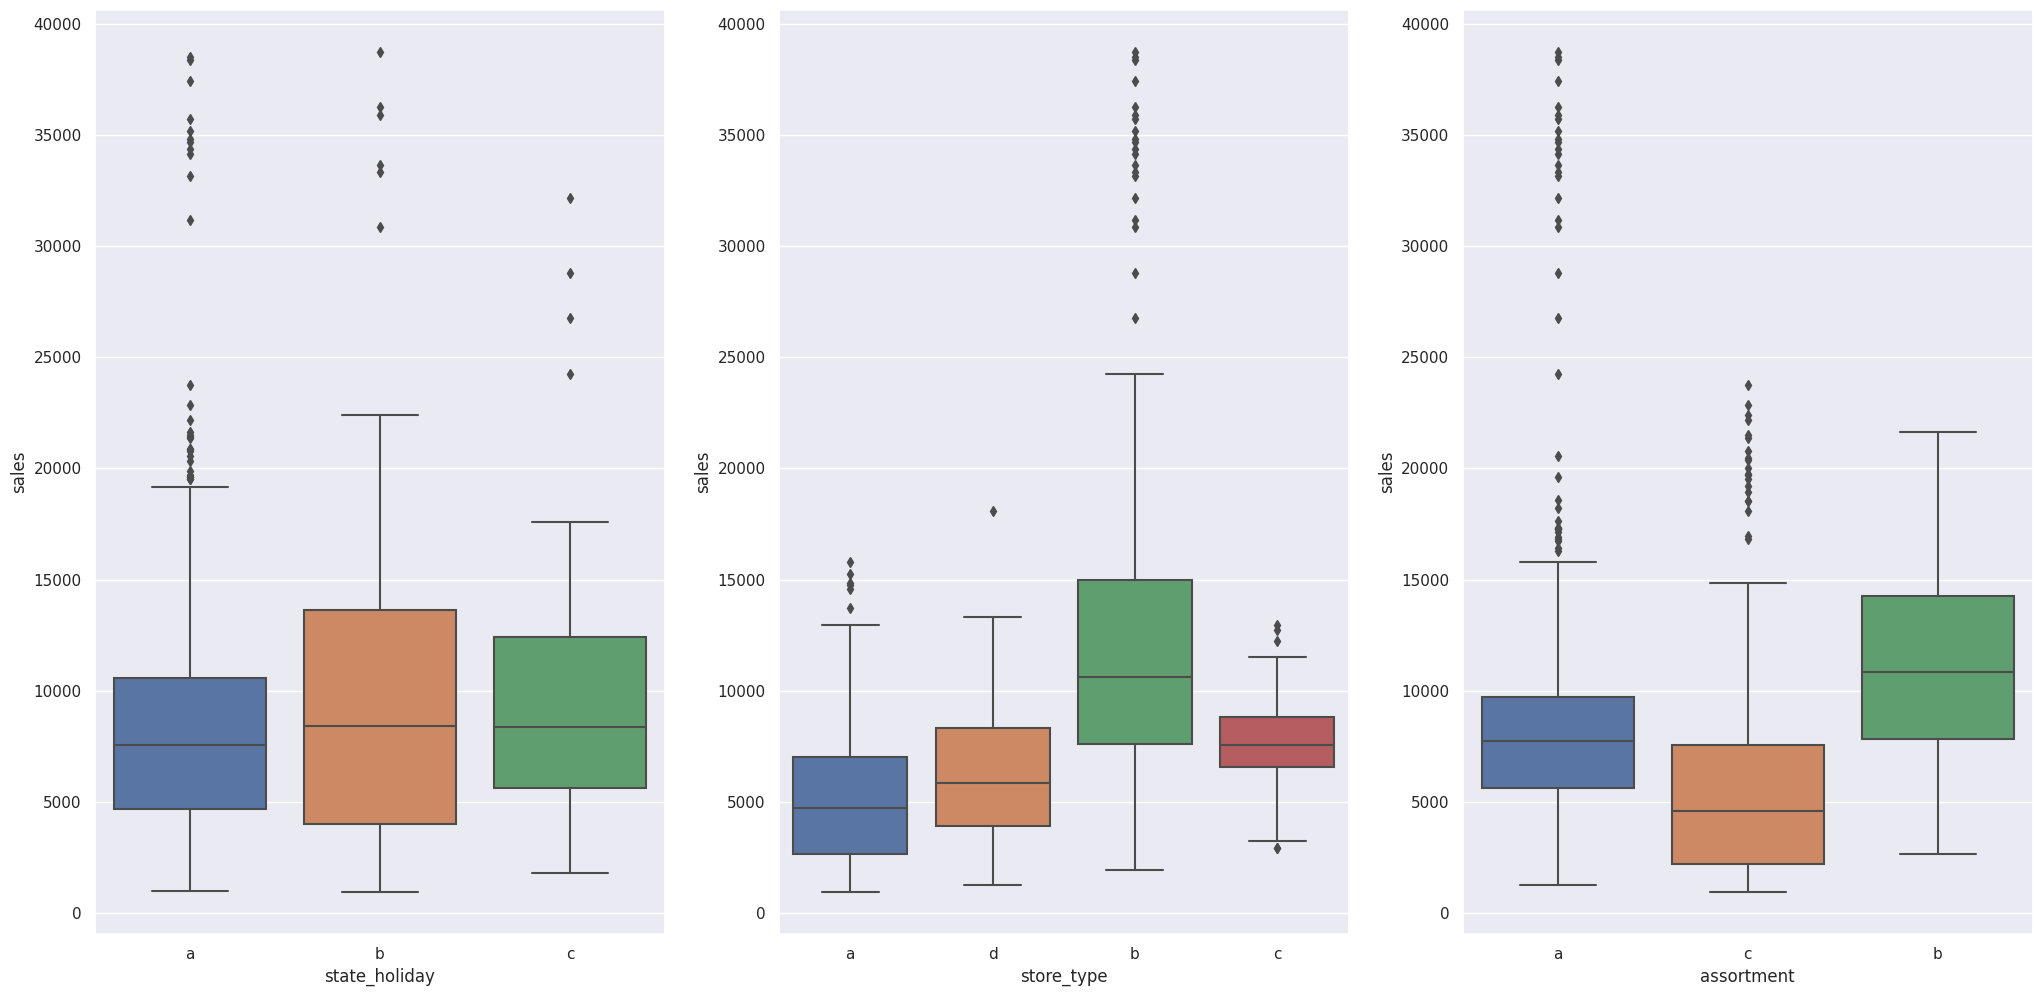

In [33]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1 )

# 2.0 Feature Engineering


## 2.1 Hypthesis Mindmap


In [34]:
df2 = df1.copy()

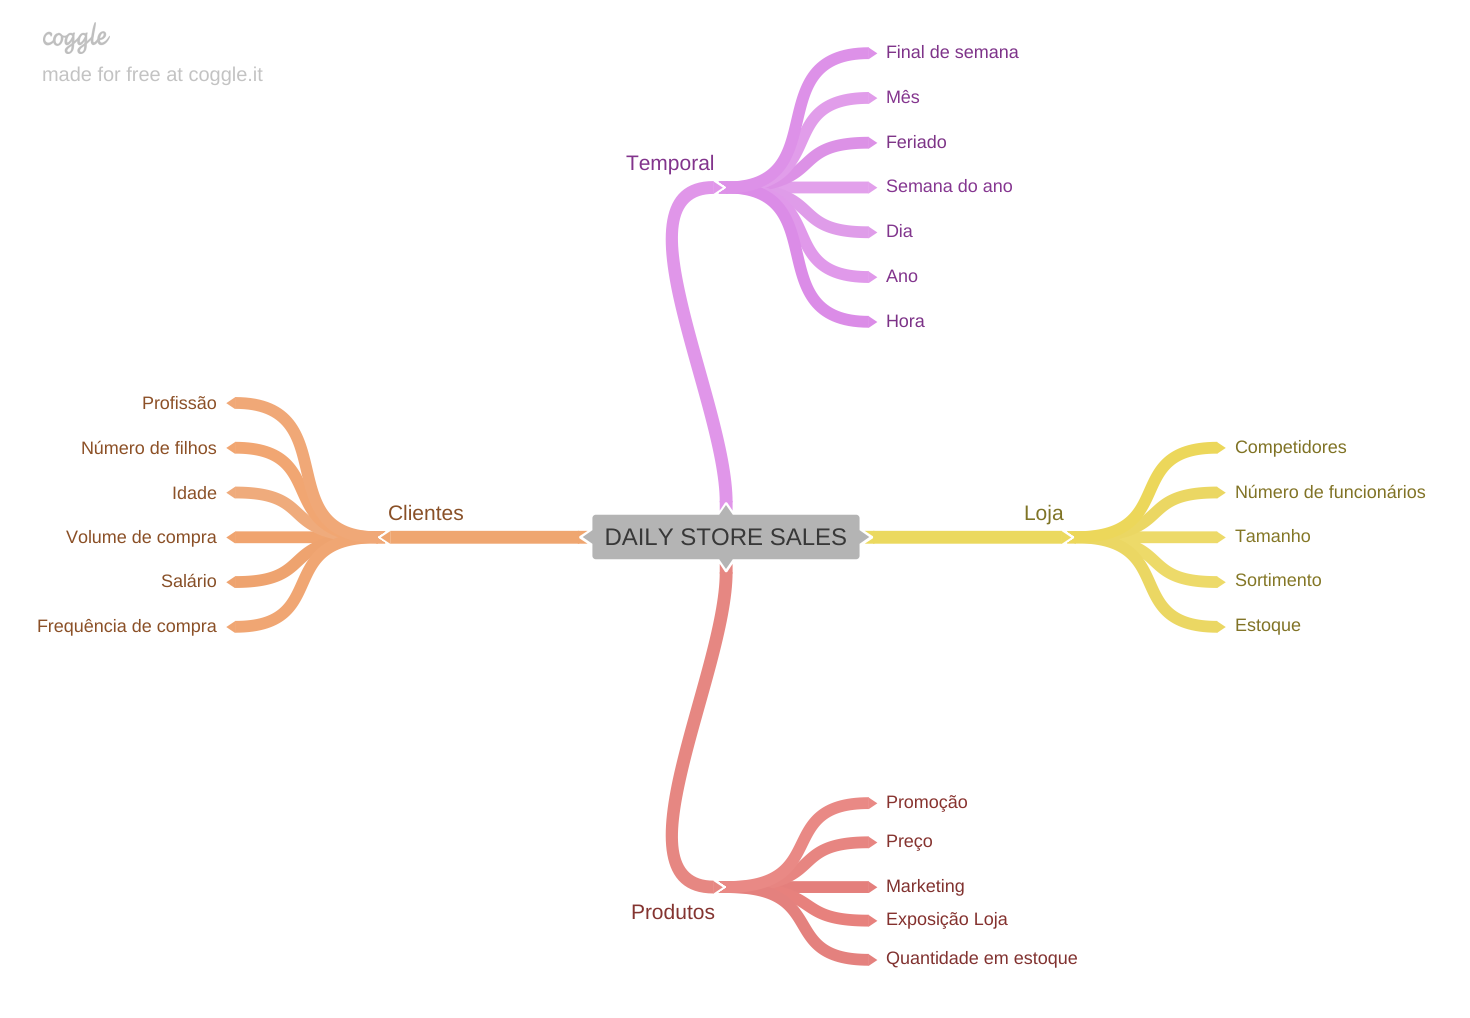

In [35]:
Image('/home/carol/repos/dsemproducao/img/MindMapHypothesis.png')

## 2.2 Hypothesis creation


### 2.2.1 Sales Hypothesis

1. Lojas com maior quadro de funcionários deveriam vender mais.

2. Lojas com maior estoque deveriam vender mais.

3. Lojas com maior porte deveriam vender mais.

5. Lojas com maior sortemente deveriam vender mais.

5. Lojas com competidores mais próximos deveriam vender menos.

6. Lojas com competidores à mais tempo deveriam vender mais.


### 2.2.2 Product's Hypothesis



1. Lojas que investem mais em Marketing deveriam vender mais.

2. Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

3. Lojas que têm preços menores nos produtos deveriam vender mais.

4. Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

5. Lojas com promoções ativas por mais tempo deveriam vender mais.

6. Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3 Time's Hypothesis



1. Lojas abertas durante o feriado de Natal deveriam vender mais.

2. Lojas deveriam vender mais ao longo dos anos.

3. Lojas deveriam vender mais no segundo sementre do ano.

4. Lojas deveriam vender mais depois do dia 10 de cada mês.

5. Lojas deveriam vender menos aos finais de semana.

6. Lojas deveriam vender menos durante os feriados escolares.


### 2.2.4 Final List



1. Lojas com maior sortimento deveriam vender mais.

2. Lojas com competidores mais próximos deveriam vender menos.

3. Lojas com competidores à mais tempo deveriam vender mais.

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

5. Lojas com mais promoções consecutivas deveriam vender mais.

6. Lojas abertas durante o feriado de Natal deveriam vender mais.

7. Lojas deveriam vender mais ao longo dos anos.

8. Lojas deveriam vender mais no segundo sementre do ano.

9. Lojas deveriam vender mais depois do dia 10 de cada mês.

10. Lojas deveriam vender menos aos finais de semana.

11. Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering


In [36]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%m')

# competition since 
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                       month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') 
                                               - datetime.timedelta(days=7) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'chrismas' if x == 'c' else 'regular_date')


In [37]:
df2.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_date,regular_date,regular_date,regular_date,regular_date
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtering variables


In [38]:
df3 = df2.copy()

In [39]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_date,1,c,basic,1270.0,9,2008,0,7,2015,0,Jul,0,2015,7,31,31,2015-07,2008-09-01,84,2015-02-09,24
1,2,5,2015-07-31,6064,625,1,1,regular_date,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-07,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_date,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-07,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_date,1,c,extended,620.0,9,2009,0,7,2015,0,Jul,0,2015,7,31,31,2015-07,2009-09-01,71,2015-02-09,24
4,5,5,2015-07-31,4822,559,1,1,regular_date,1,a,basic,29910.0,4,2015,0,7,2015,0,Jul,0,2015,7,31,31,2015-07,2015-04-01,4,2015-02-09,24


## 3.1 Filtering lines


In [40]:
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtering columns

In [41]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [42]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_date,1,c,basic,1270.0,9,2008,0,7,2015,0,2015,7,31,31,2015-07,2008-09-01,84,2015-02-09,24
1,2,5,2015-07-31,6064,1,regular_date,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-07,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_date,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-07,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_date,1,c,extended,620.0,9,2009,0,7,2015,0,2015,7,31,31,2015-07,2009-09-01,71,2015-02-09,24
4,5,5,2015-07-31,4822,1,regular_date,1,a,basic,29910.0,4,2015,0,7,2015,0,2015,7,31,31,2015-07,2015-04-01,4,2015-02-09,24


# 4.0 - Exploratory Data Analysis

In [43]:
df4 = df3.copy()

## 4.1 Univariate Analysis


### 4.1.1 Response Variable


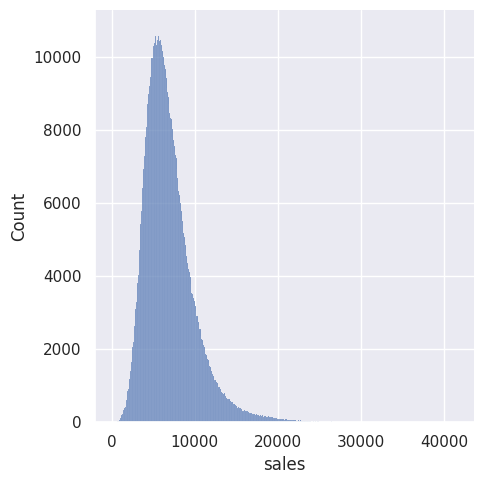

In [44]:
sns.displot( df4['sales'], kde=False)

### 4.1.2 Numerical Variable


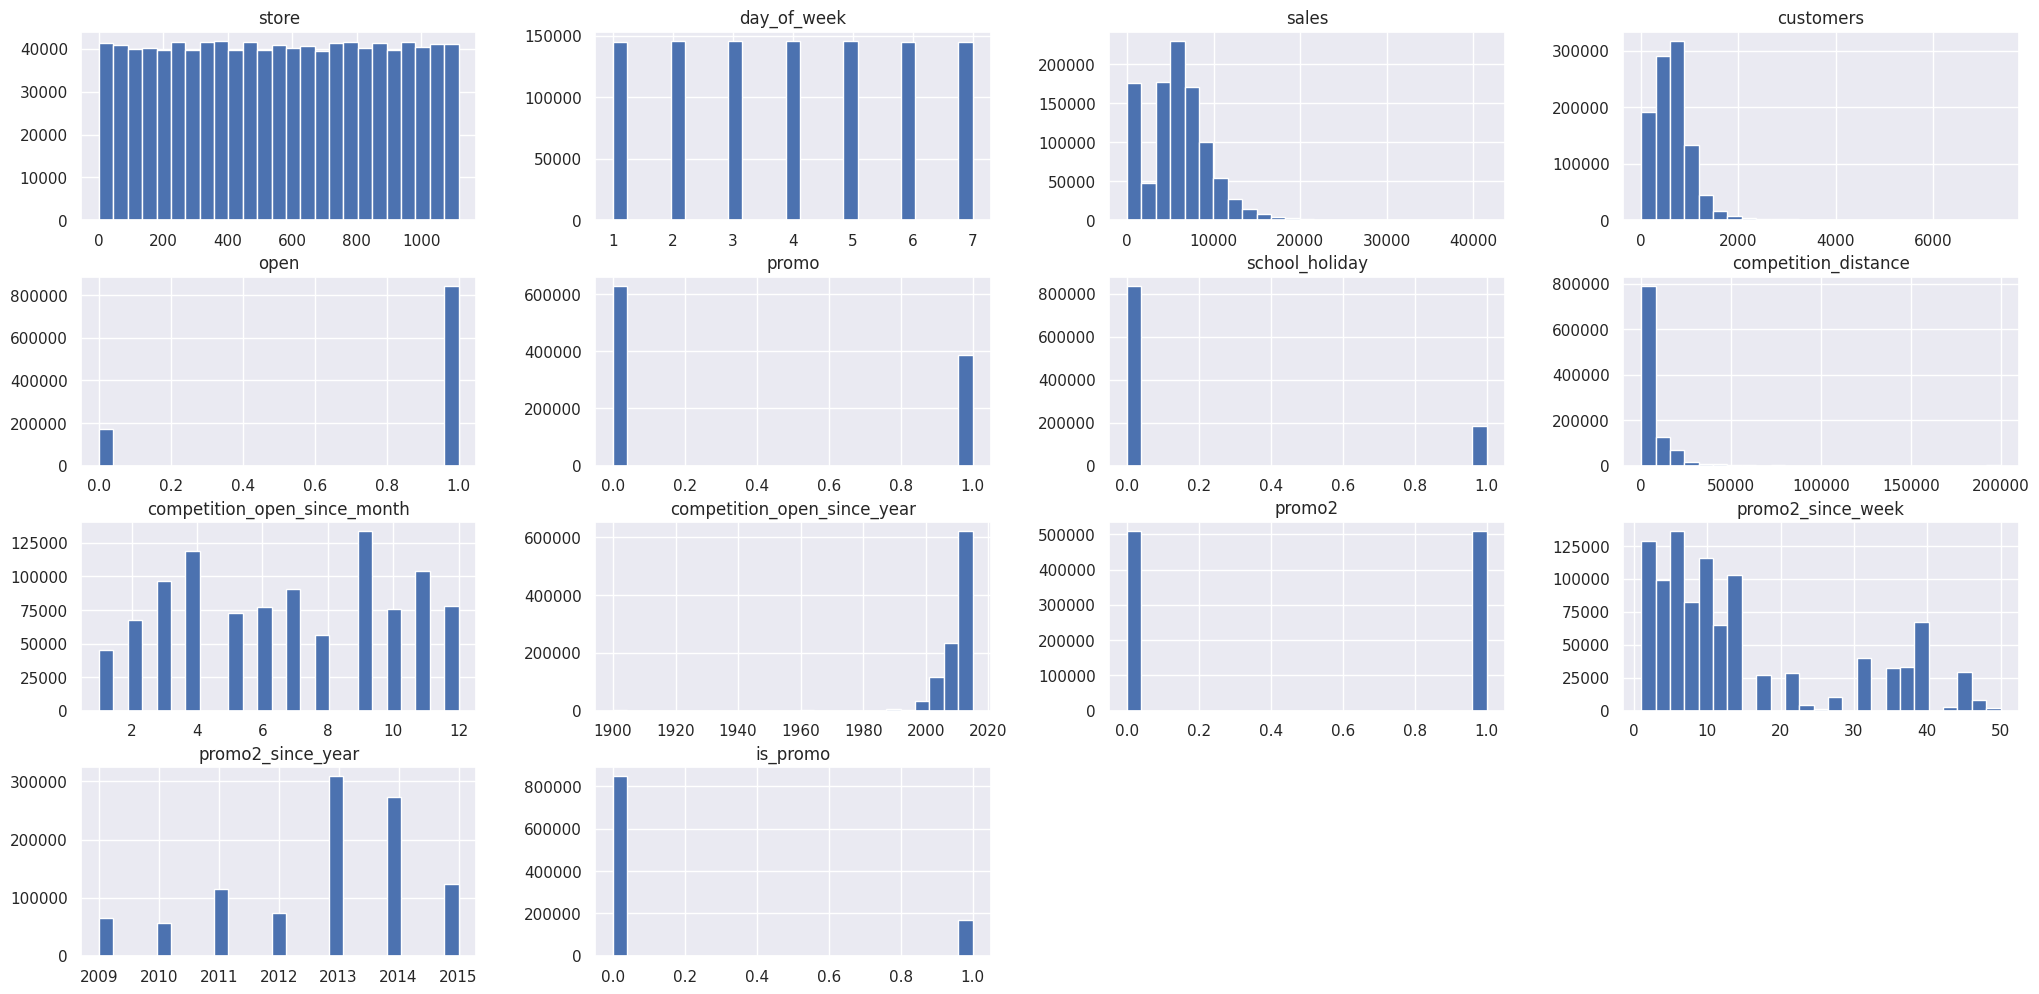

In [45]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical Variable

<Axes: xlabel='sales', ylabel='Density'>

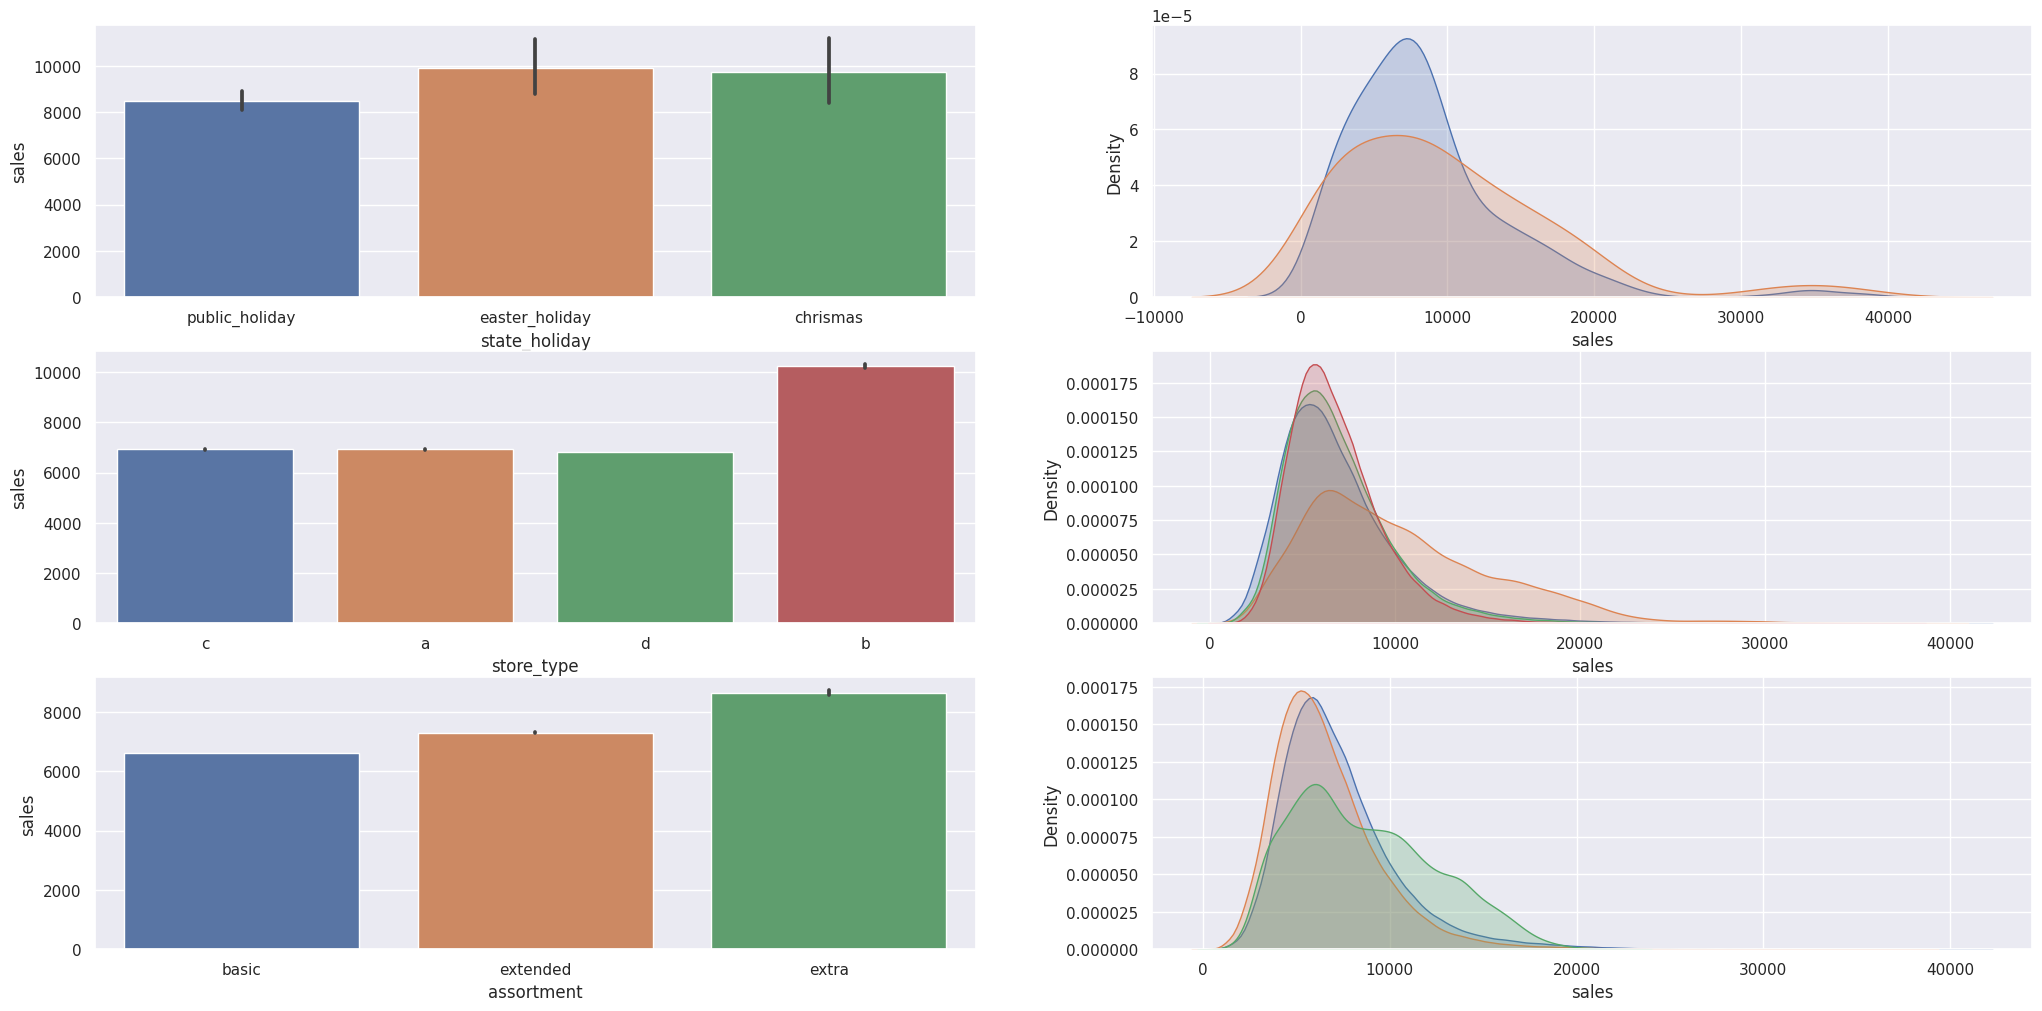

In [46]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4["state_holiday"] != "regular_date"]
sns.barplot(a, x = 'state_holiday', y = 'sales')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", fill=True)
sns.kdeplot(df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", fill=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.barplot(df4, x = 'store_type', y = 'sales')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4["store_type"] == "a"]["sales"], label="a", fill=True)
sns.kdeplot(df4[df4["store_type"] == "b"]["sales"], label="b", fill=True)
sns.kdeplot(df4[df4["store_type"] == "c"]["sales"], label="b", fill=True)
sns.kdeplot(df4[df4["store_type"] == "d"]["sales"], label="b", fill=True)

# Assortment
plt.subplot(3, 2, 5)
sns.barplot(df4, x = 'assortment', y = 'sales')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4["assortment"] == "extended"]["sales"], label="extended", fill=True)
sns.kdeplot(df4[df4["assortment"] == "basic"]["sales"], label="basic", fill=True)
sns.kdeplot(df4[df4["assortment"] == "extra"]["sales"], label="extra", fill=True)


## 4.2 Bivariate Analysis

H1: Lojas com maior sortimento deveriam vender mais

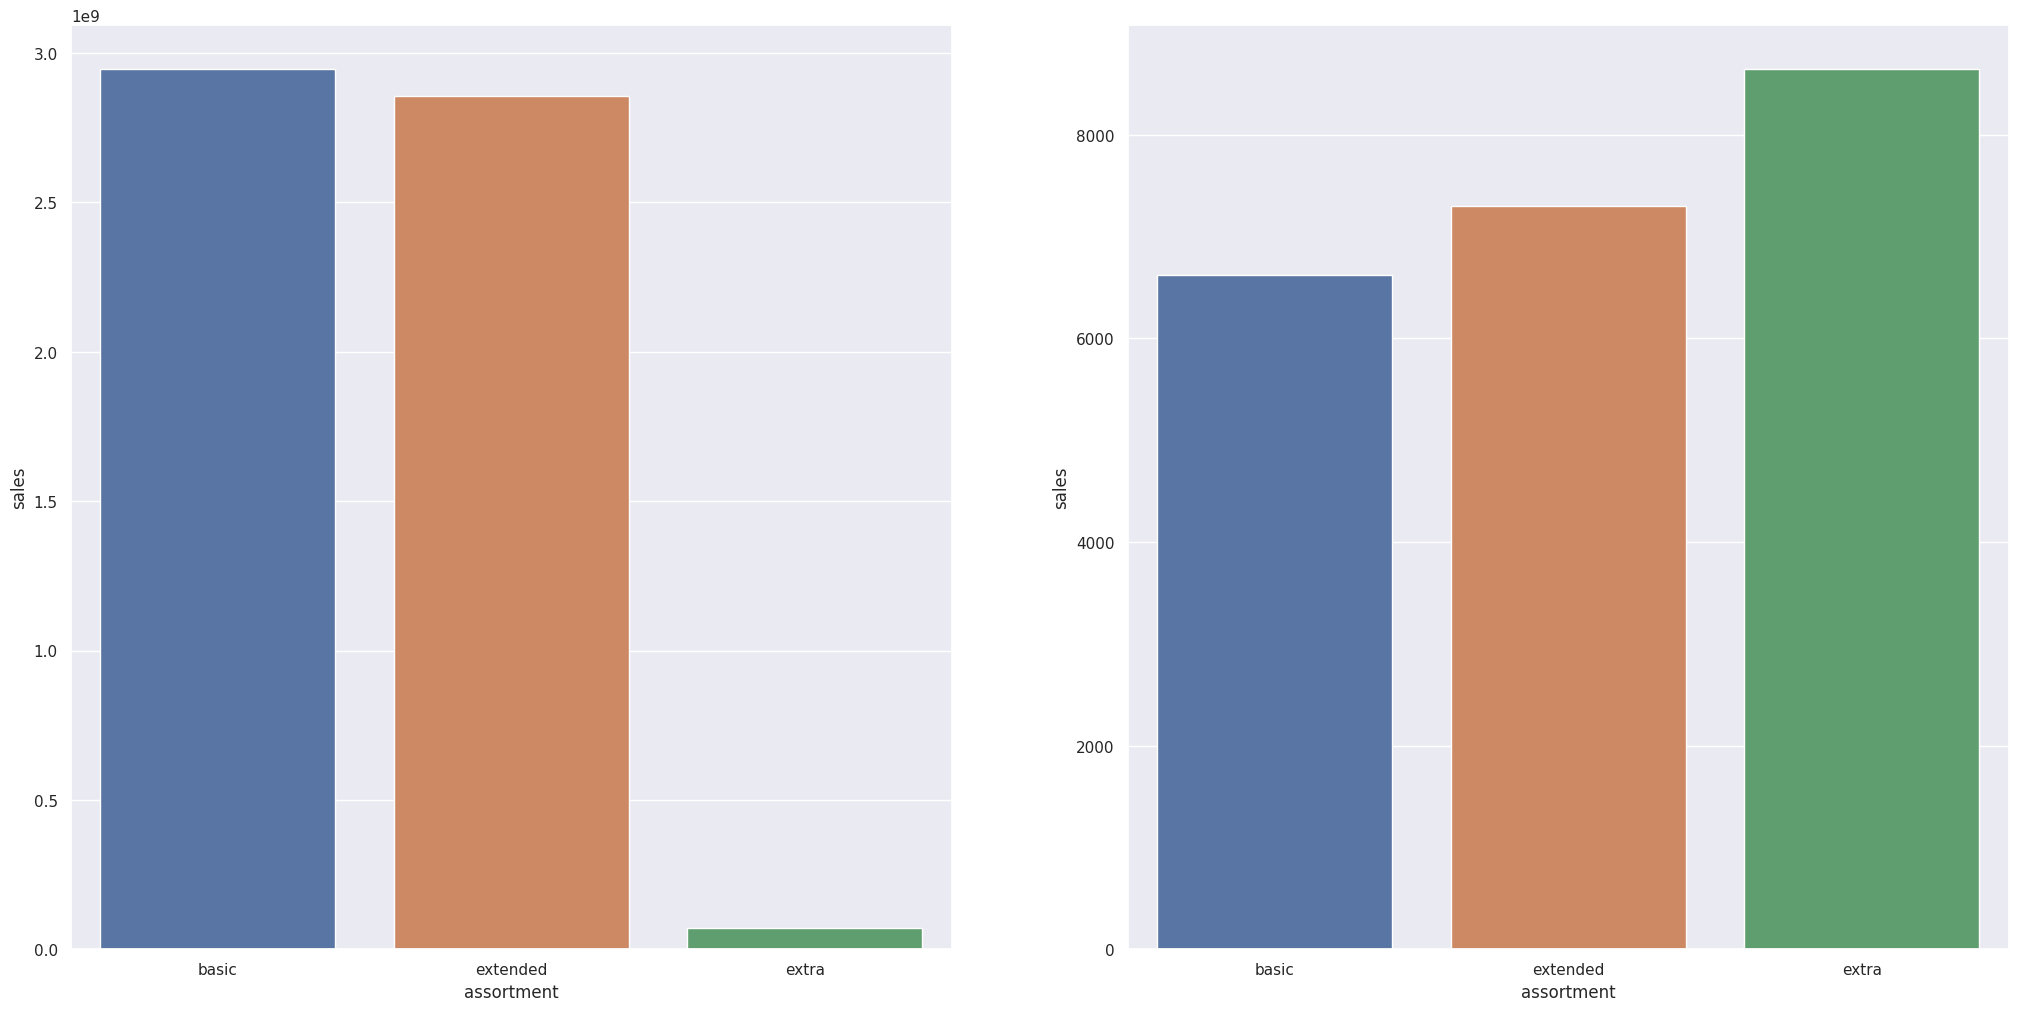

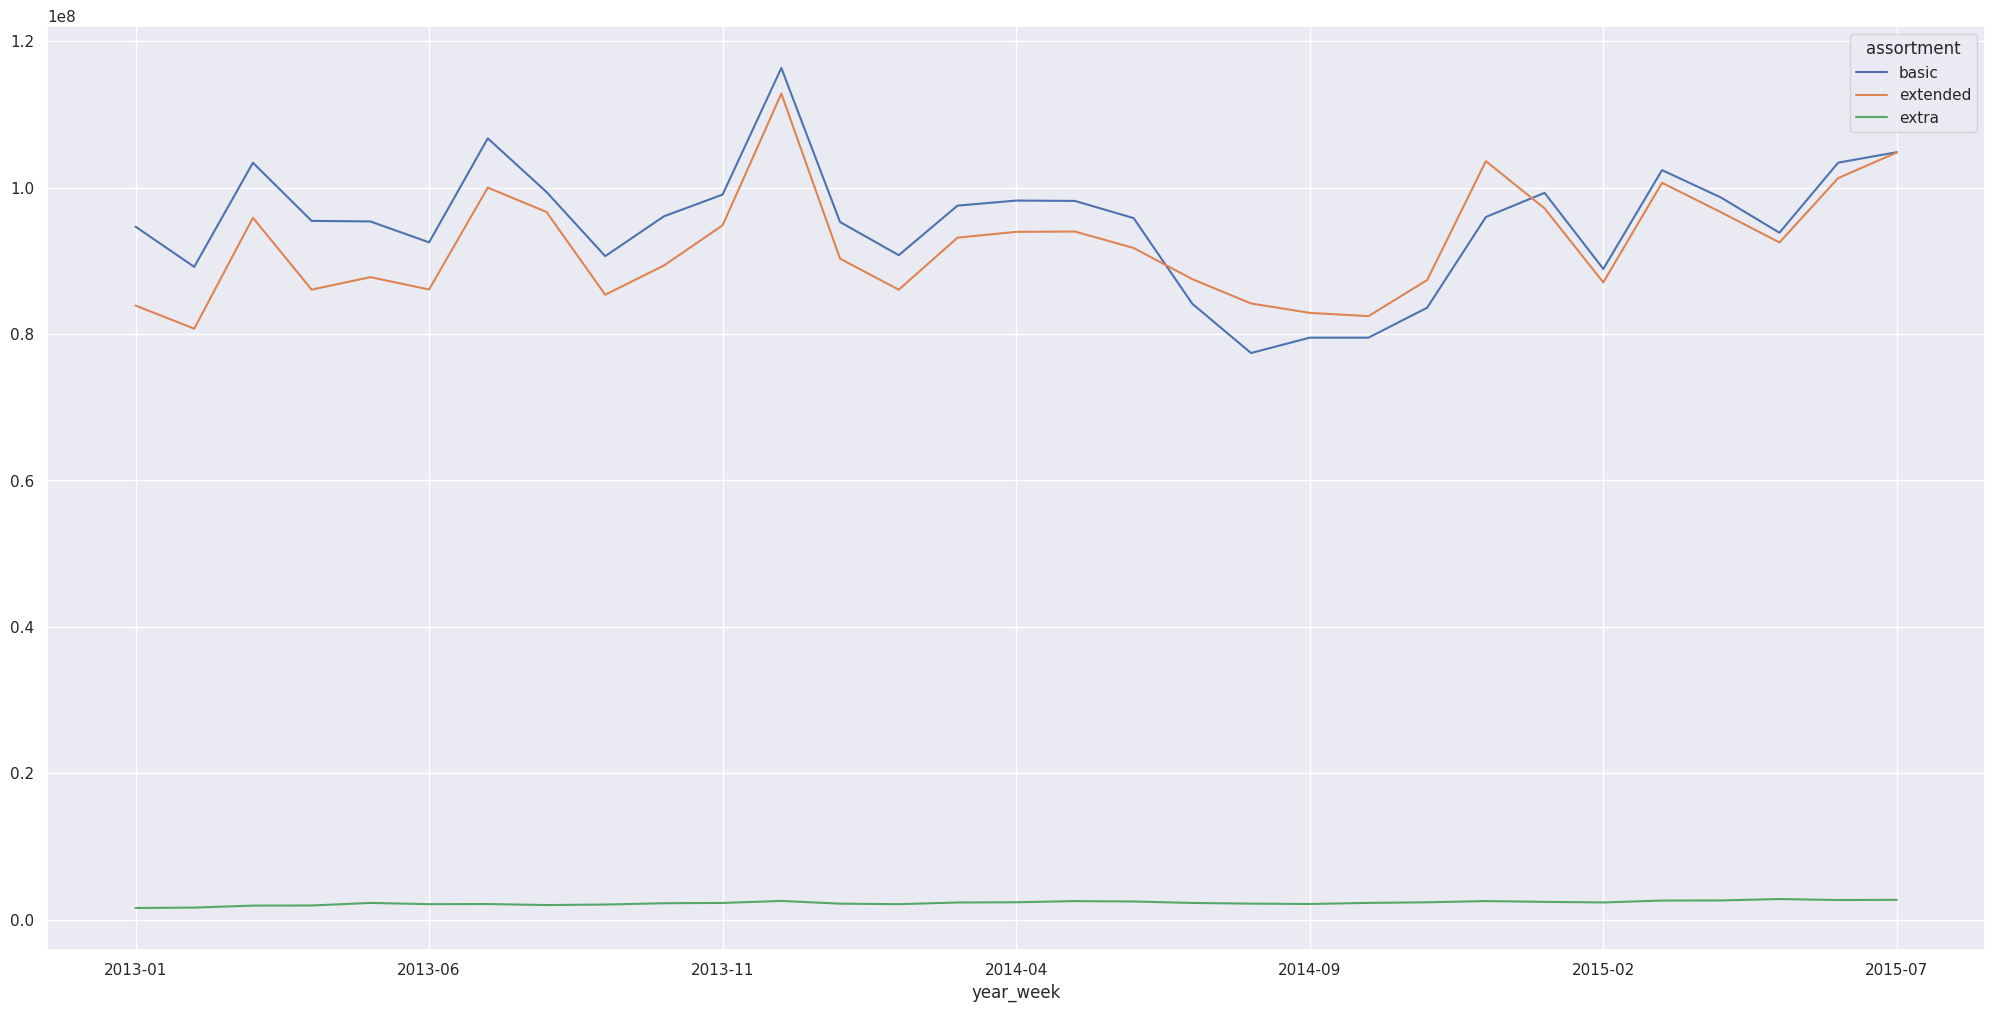

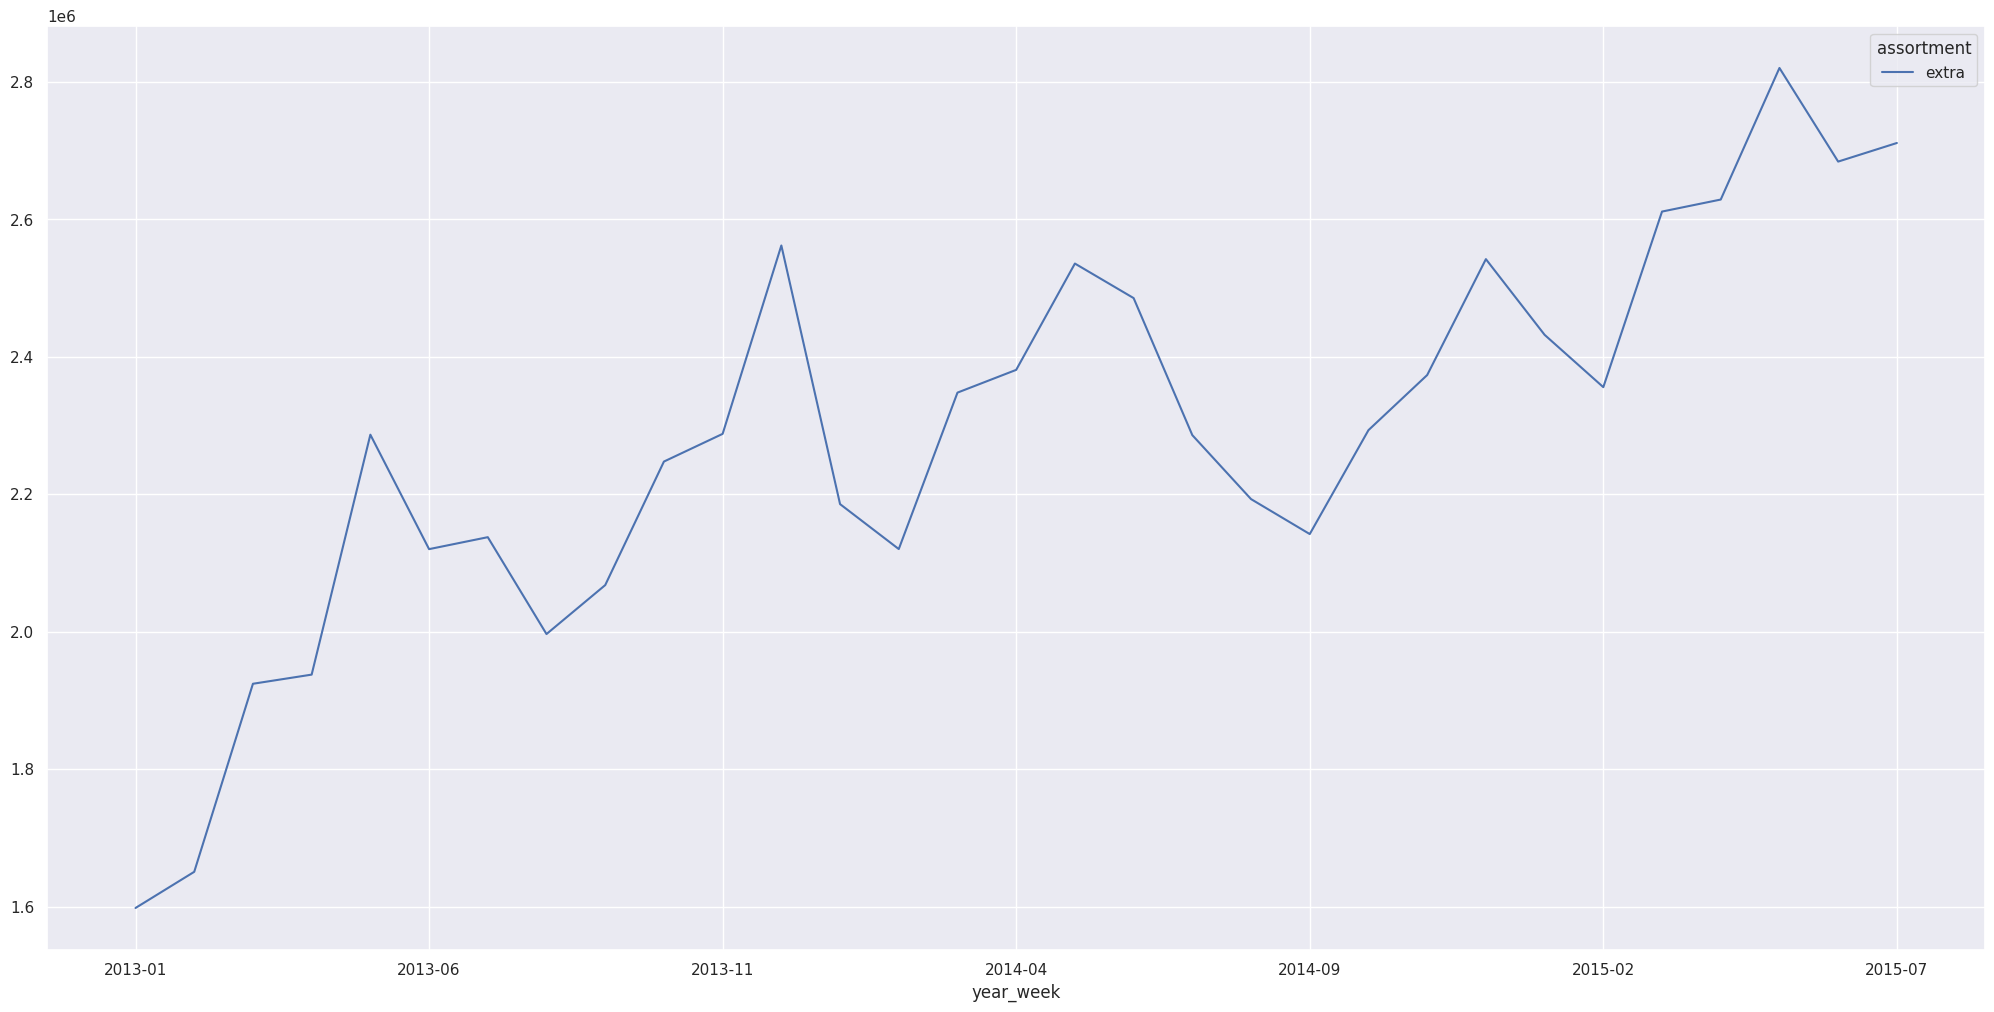

In [47]:
plt.subplot( 1, 2, 1)
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1)

plt.subplot( 1, 2, 2)
aux2 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux2);

aux3 = df4[[ 'year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux3.pivot( index='year_week', columns='assortment', values='sales').plot();

aux4 = aux3[aux3['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='sales').plot();

H2: Lojas com competidores mais próximos deveriam vender menos.

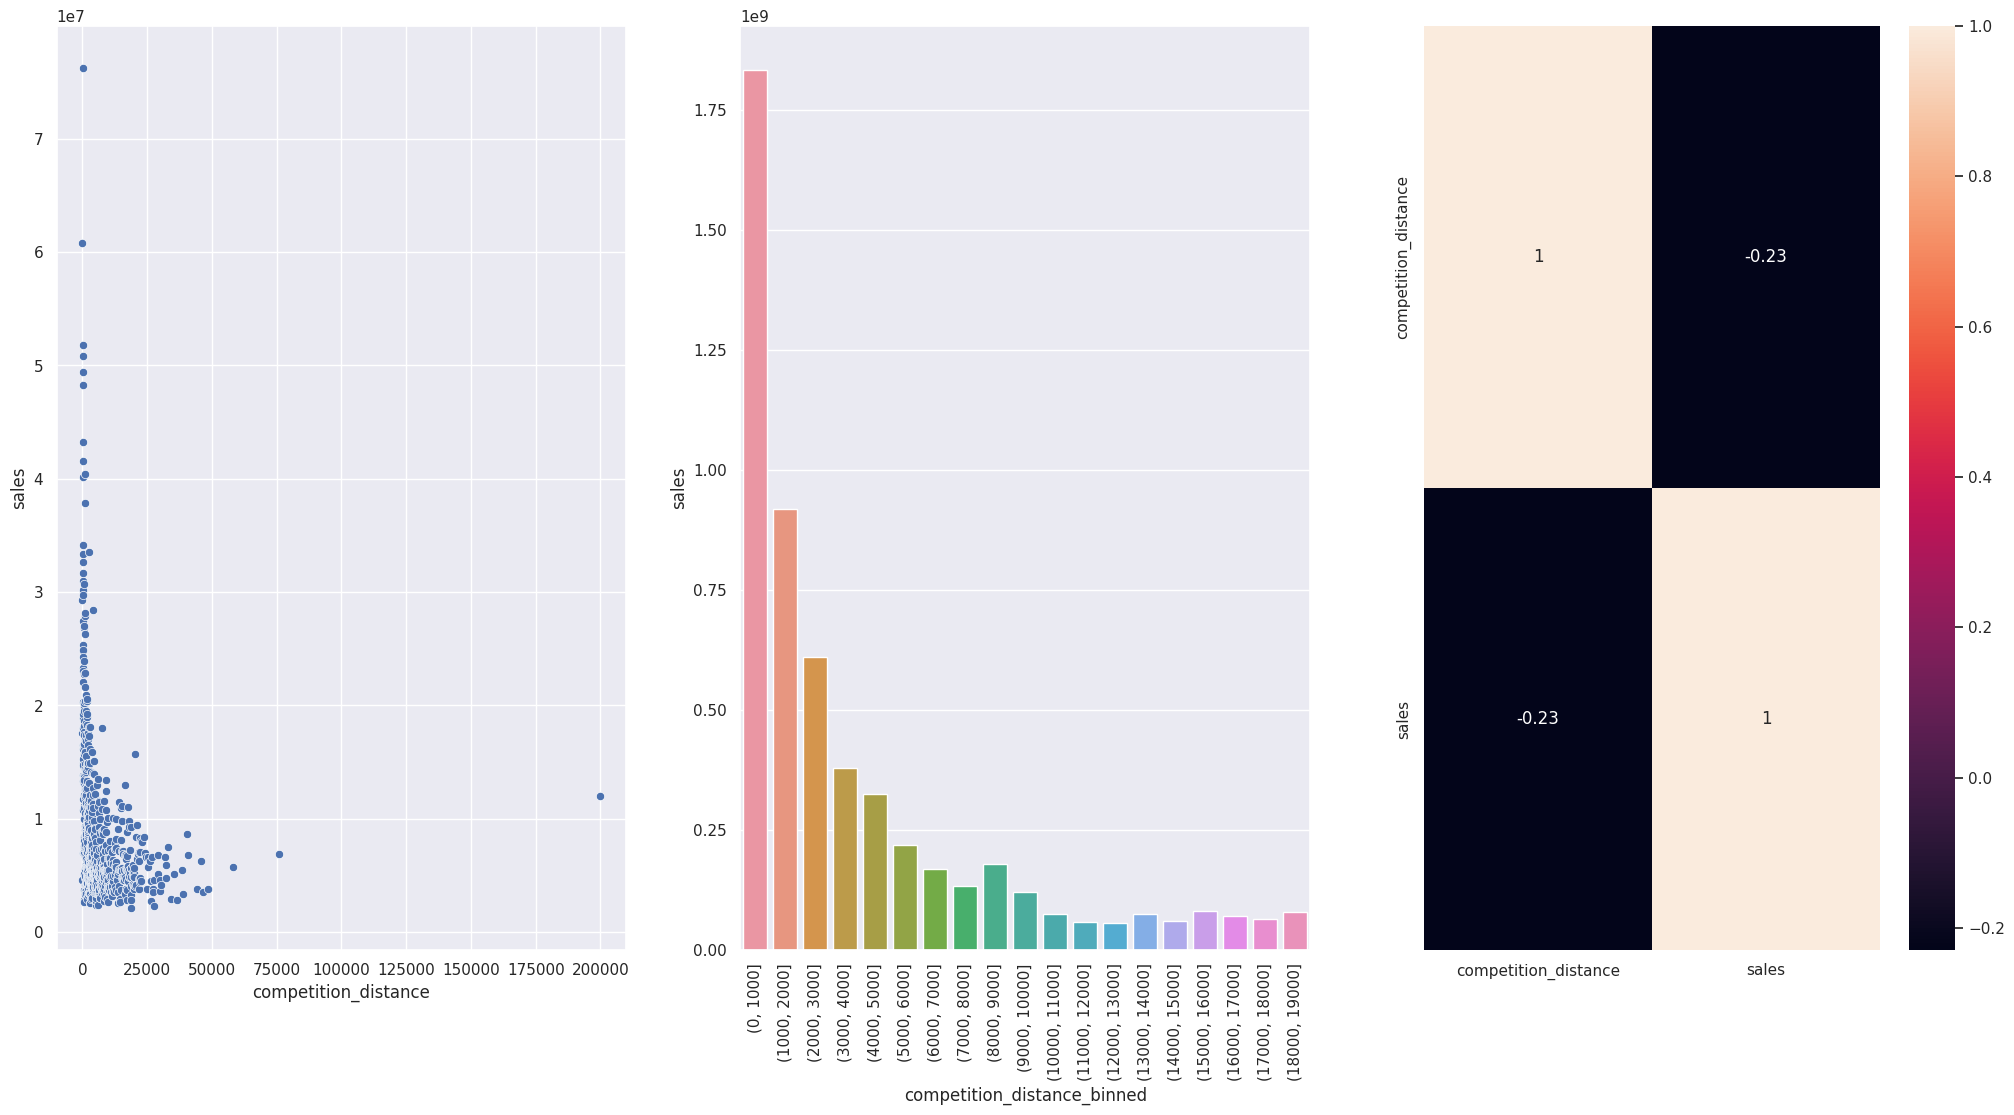

In [48]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot( 1, 3, 2)
bins = list( np.arange( 0, 20000, 1000 ) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2)
plt.xticks( rotation=90 );

H3: Lojas com competidores há mais tempo deveriam vendem mais.

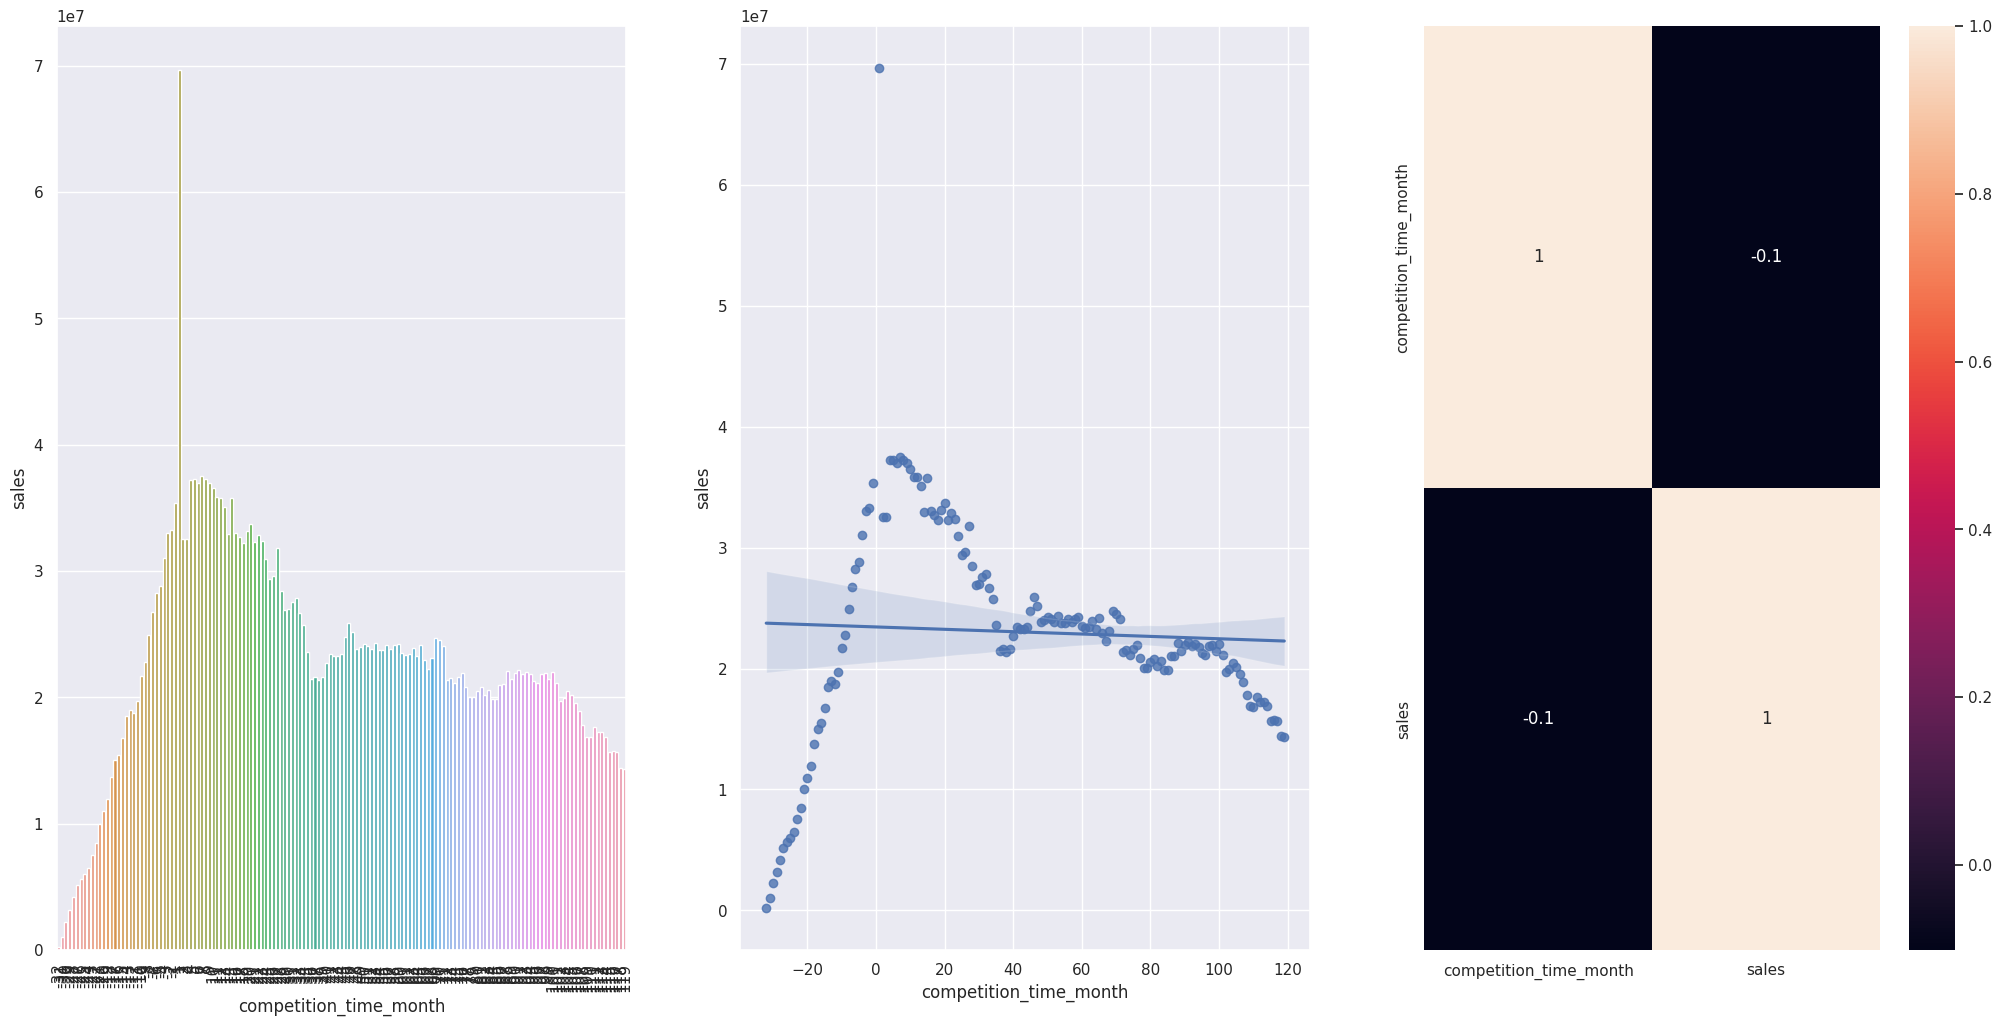

In [49]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

H4: Lojas com promoções ativas por mais tempo deveriam vender mais.

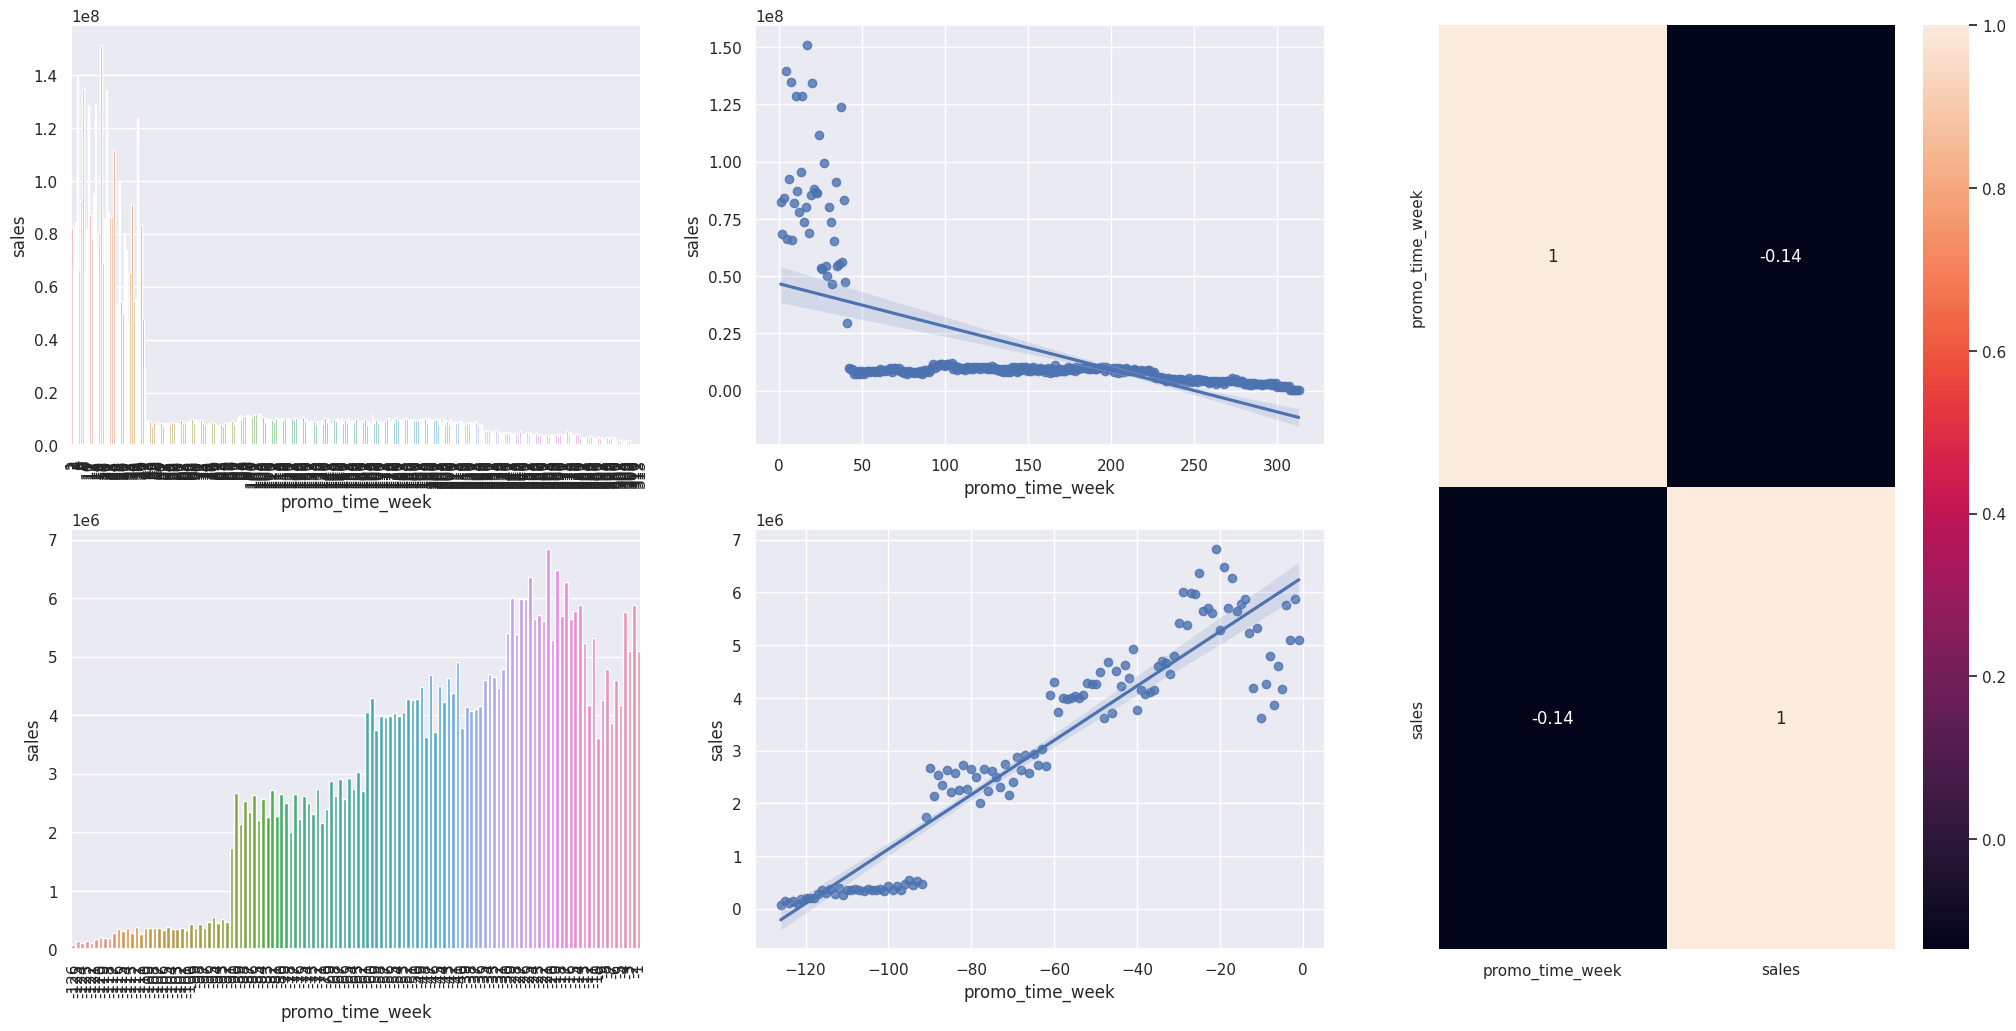

In [50]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # periodo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 )

plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # periodo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

H5: Lojas com mais promoções consecutivas deveriam vender mais.

In [51]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index().sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


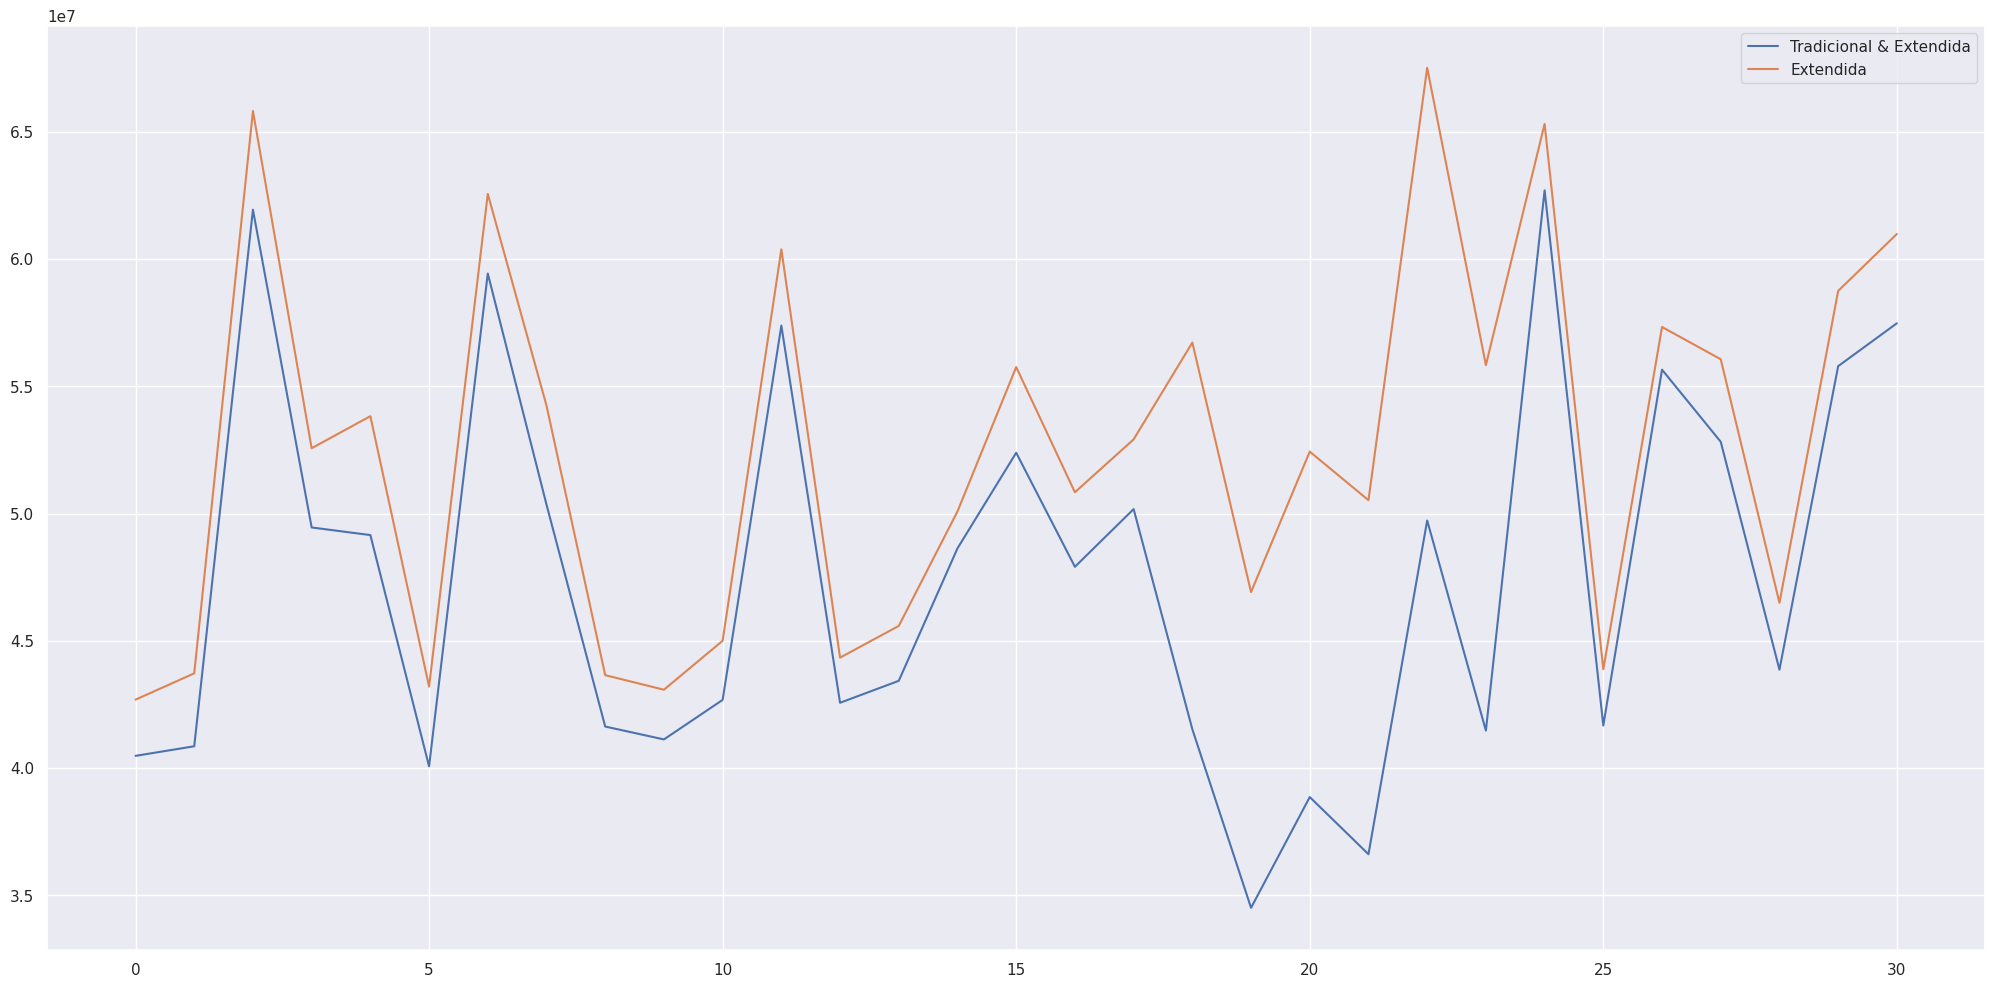

In [52]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels= ['Tradicional & Extendida', 'Extendida']);

H6: Lojas abertas durante o feriado de Natal deveriam vender mais.

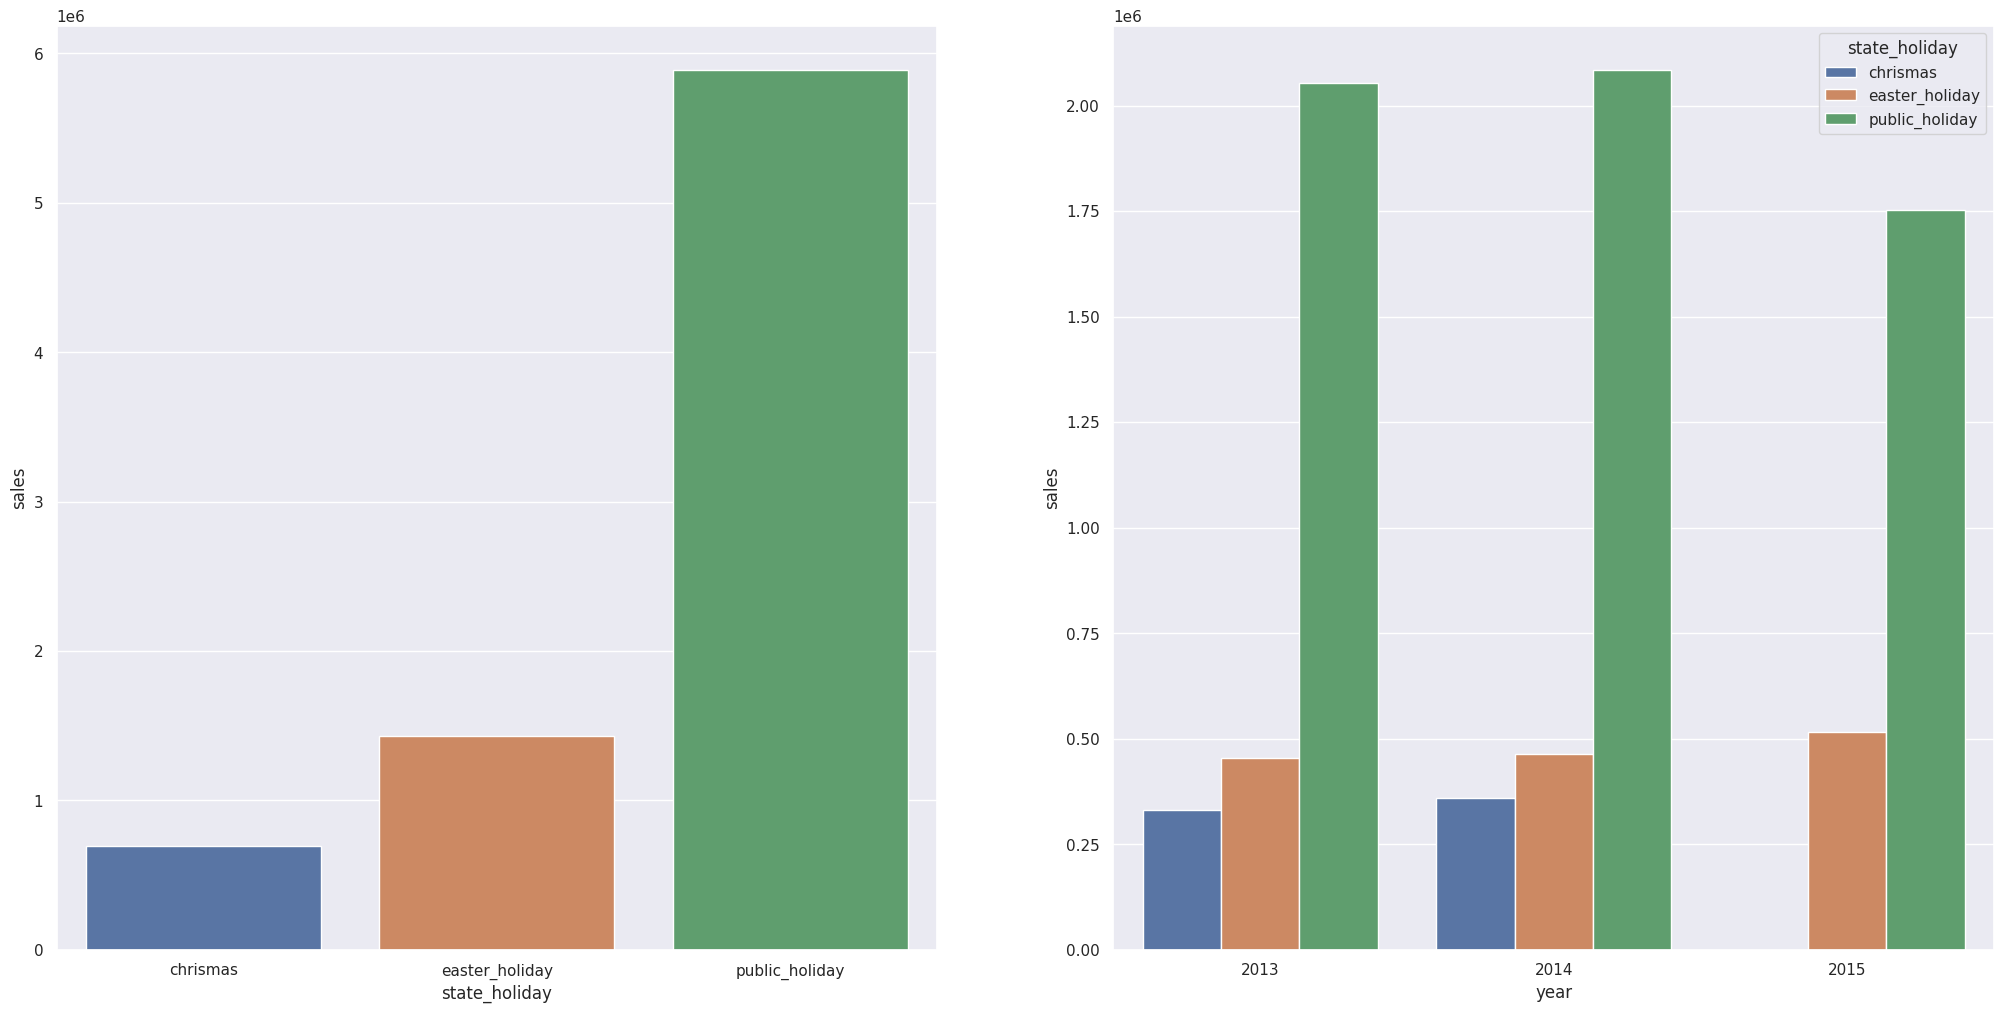

In [53]:
aux = df4[df4['state_holiday'] != 'regular_date']

plt.subplot( 1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

H7: Lojas deveriam vender mais ao longo dos anos.

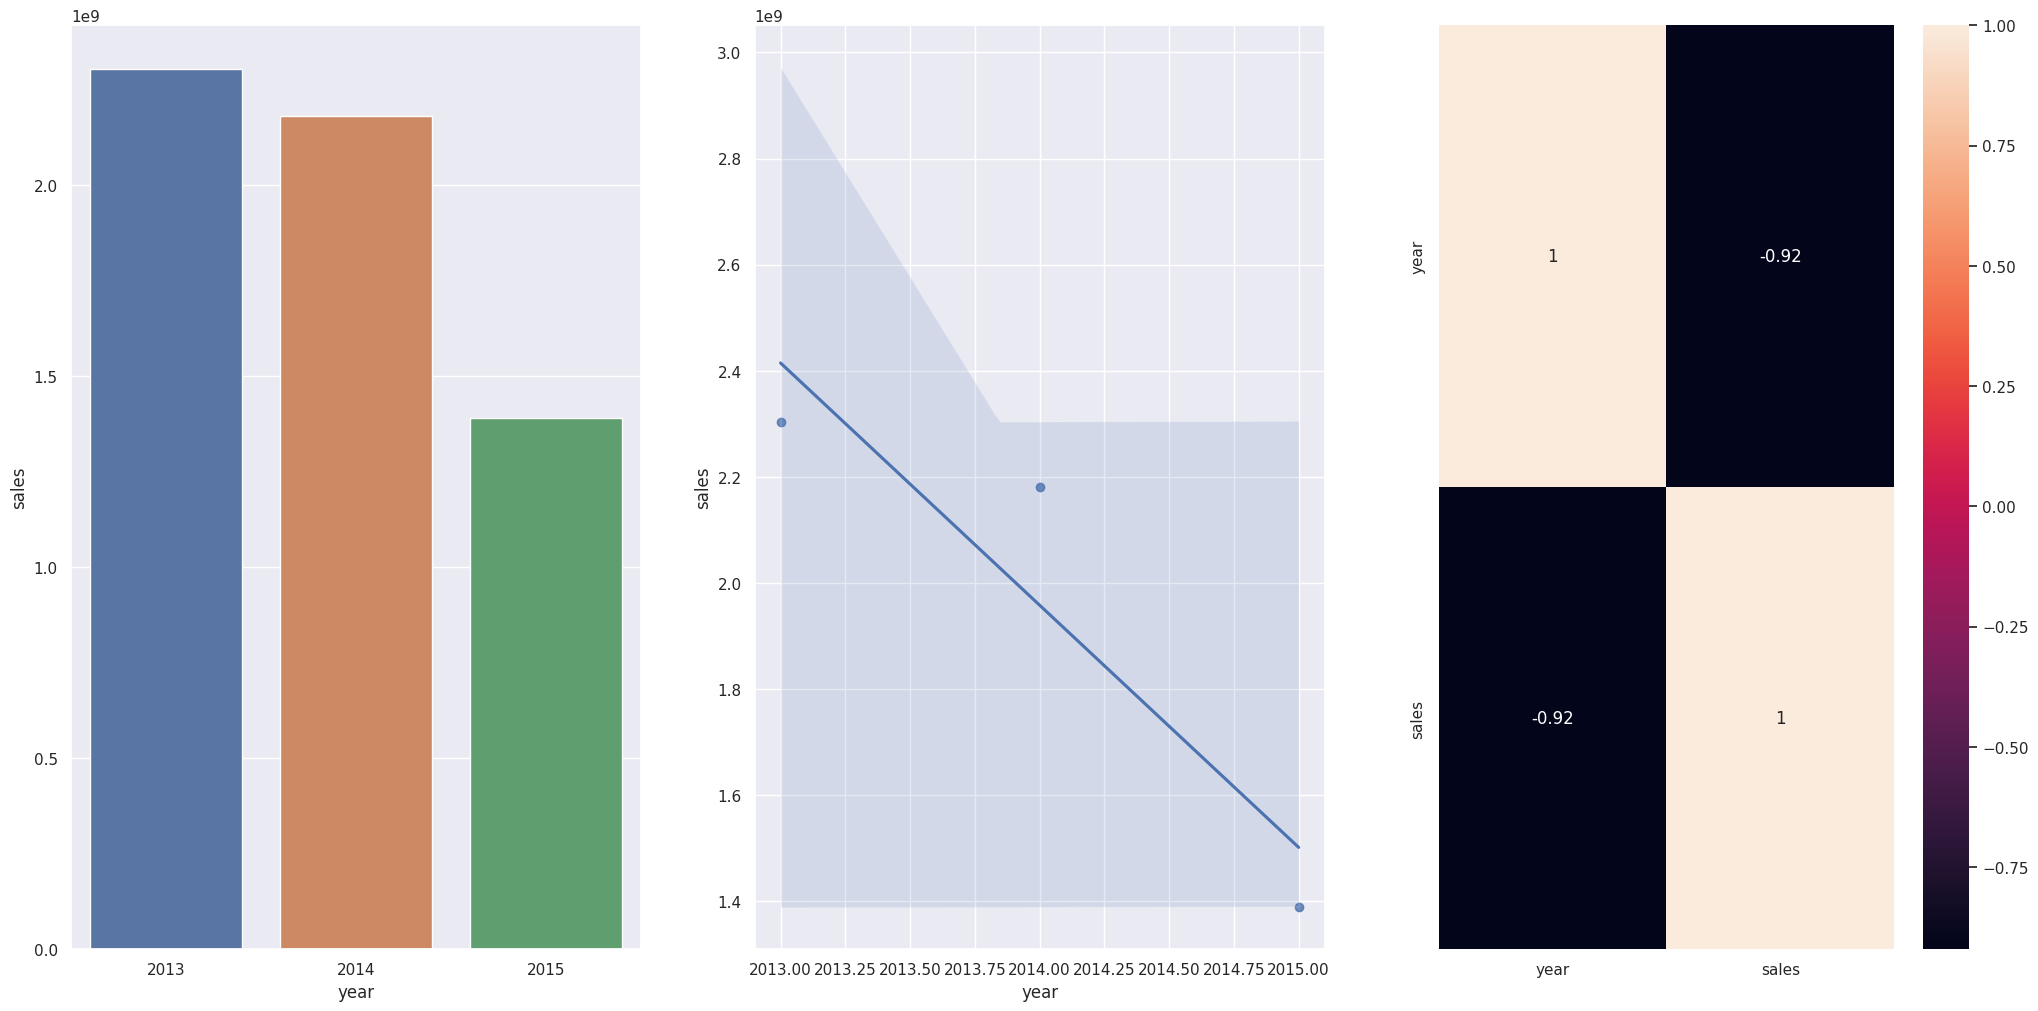

In [54]:
plt.subplot( 1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

H8: Lojas deveriam vender mais no segundo semestre do ano.

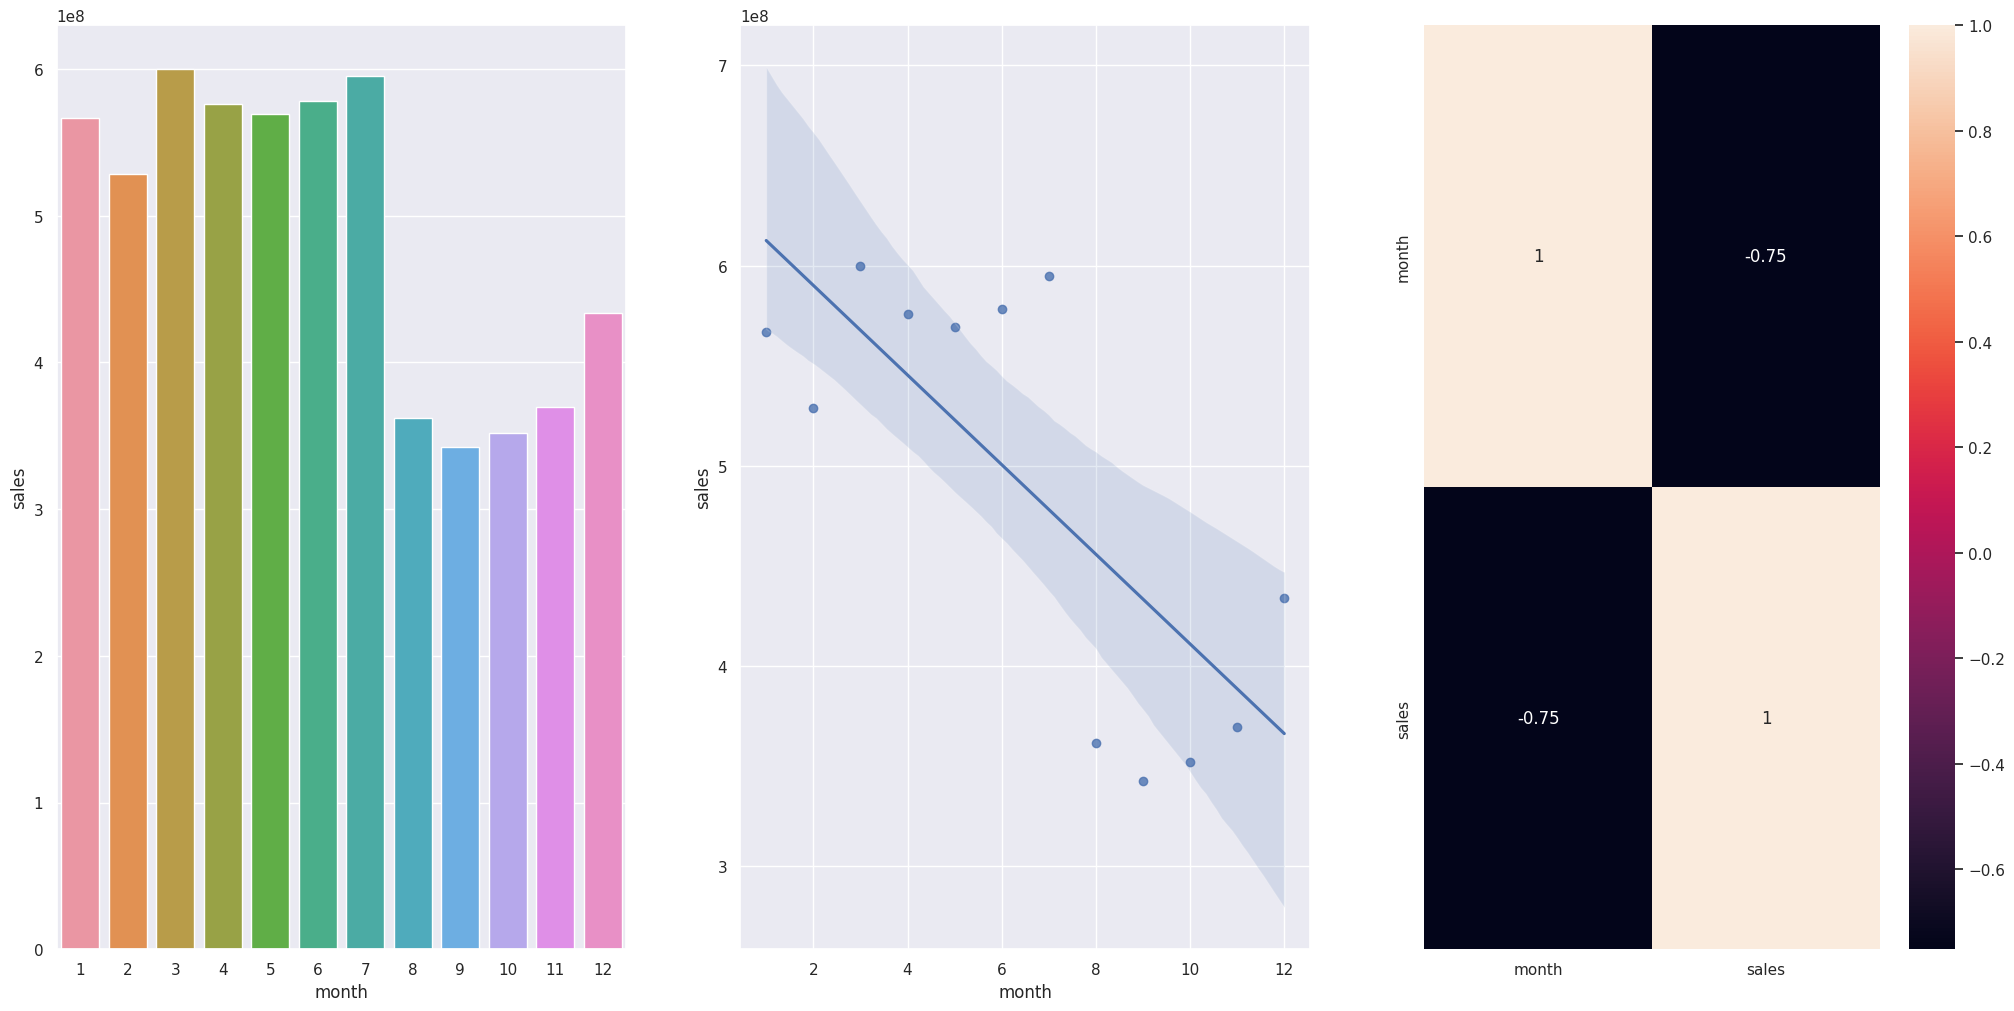

In [55]:
plt.subplot( 1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

H9: Lojas deveriam vender mais depois do dia 10 de cada mês.

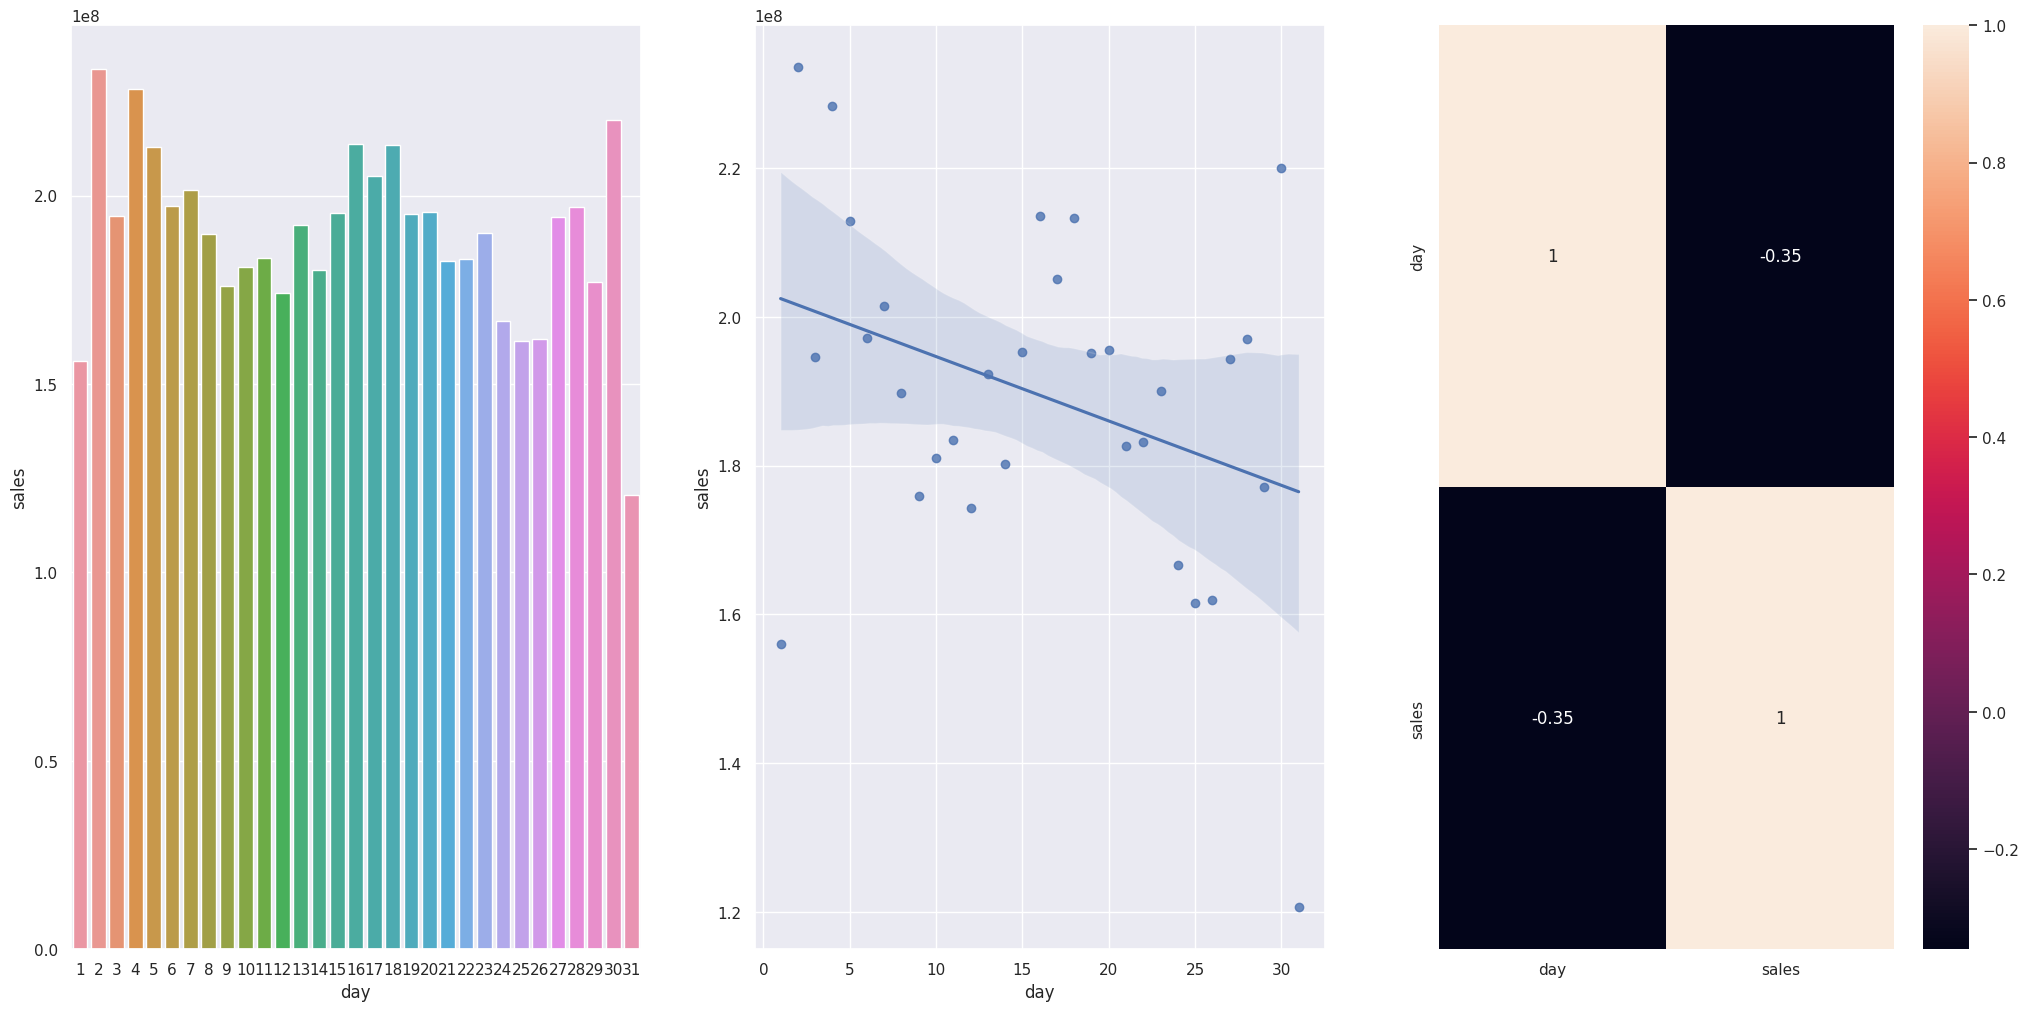

In [56]:
plt.subplot( 1, 3, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

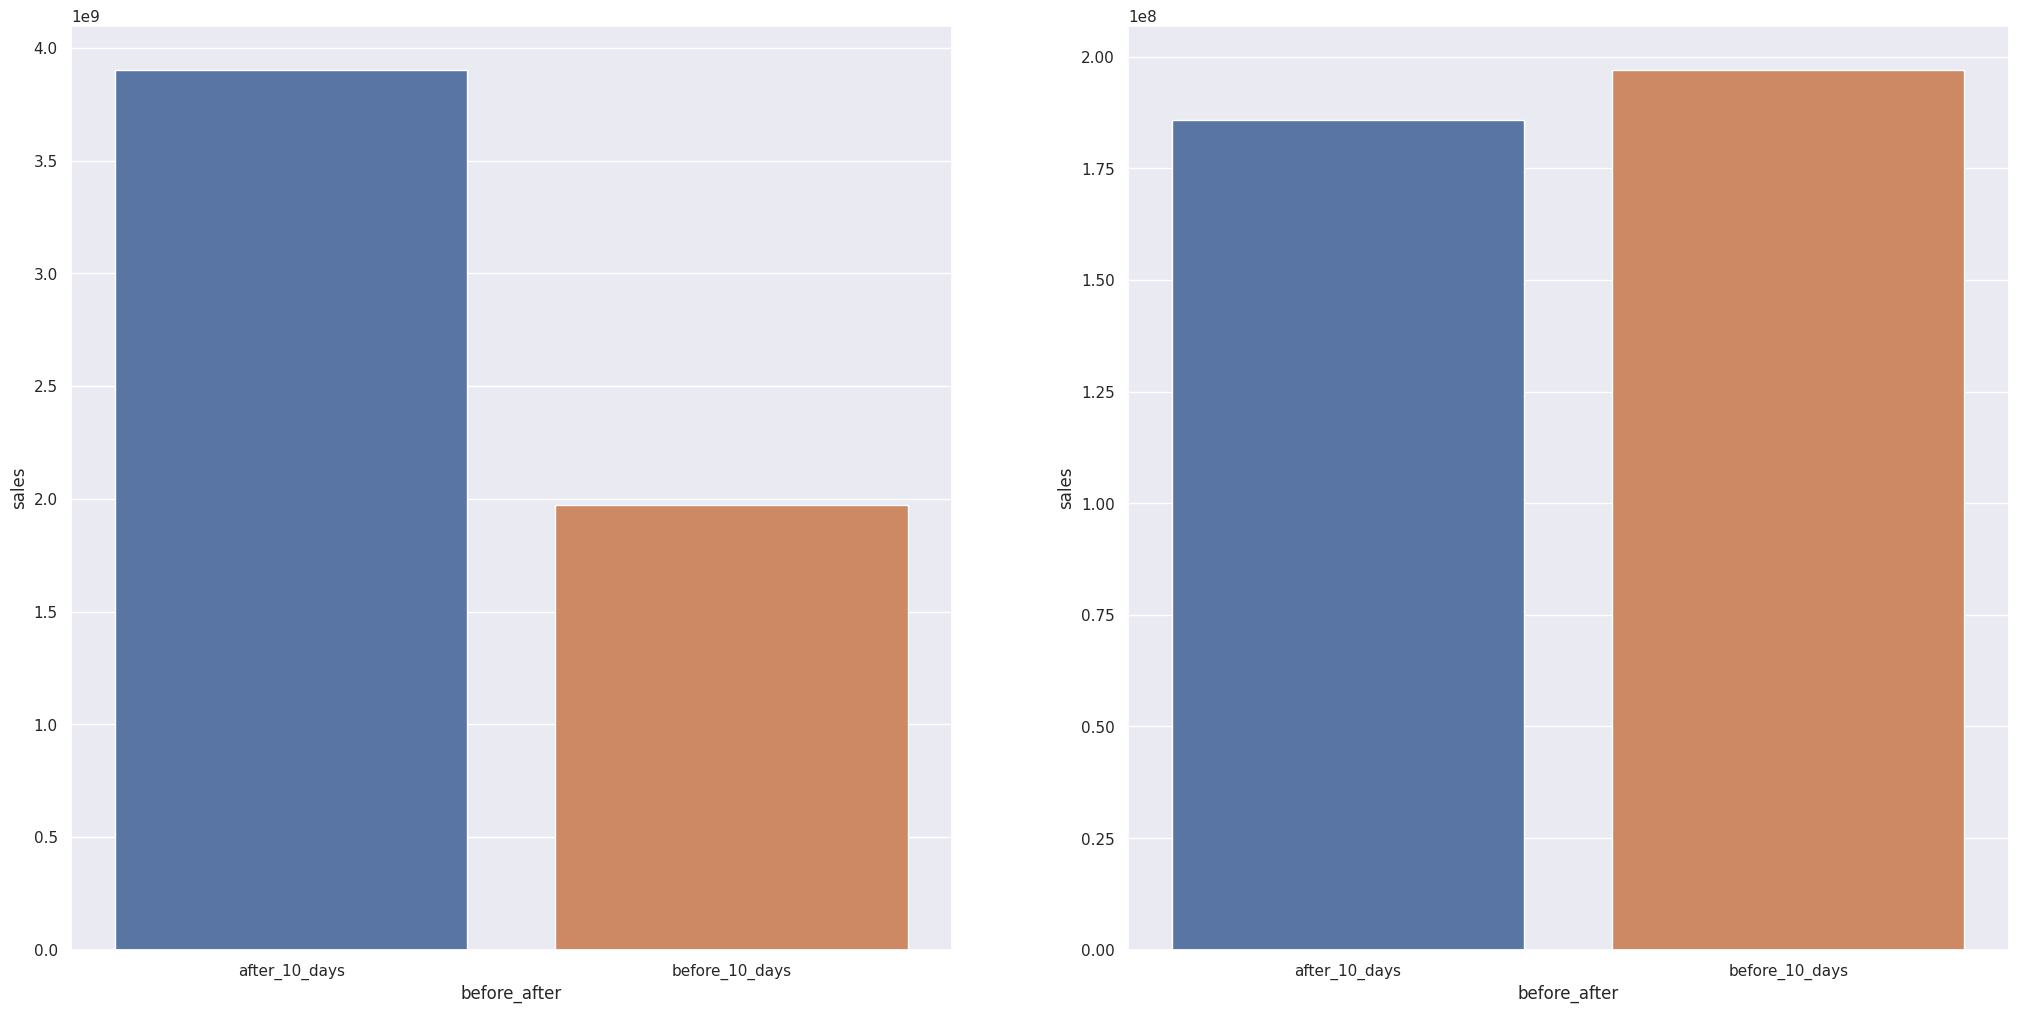

In [57]:
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

plt.subplot( 1, 2, 1 )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2);

plt.subplot( 1, 2, 2 )
aux3 = aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()
sns.barplot( x='before_after', y='sales', data=aux3);

H10: Lojas deveriam vender menos aos finais de semana.

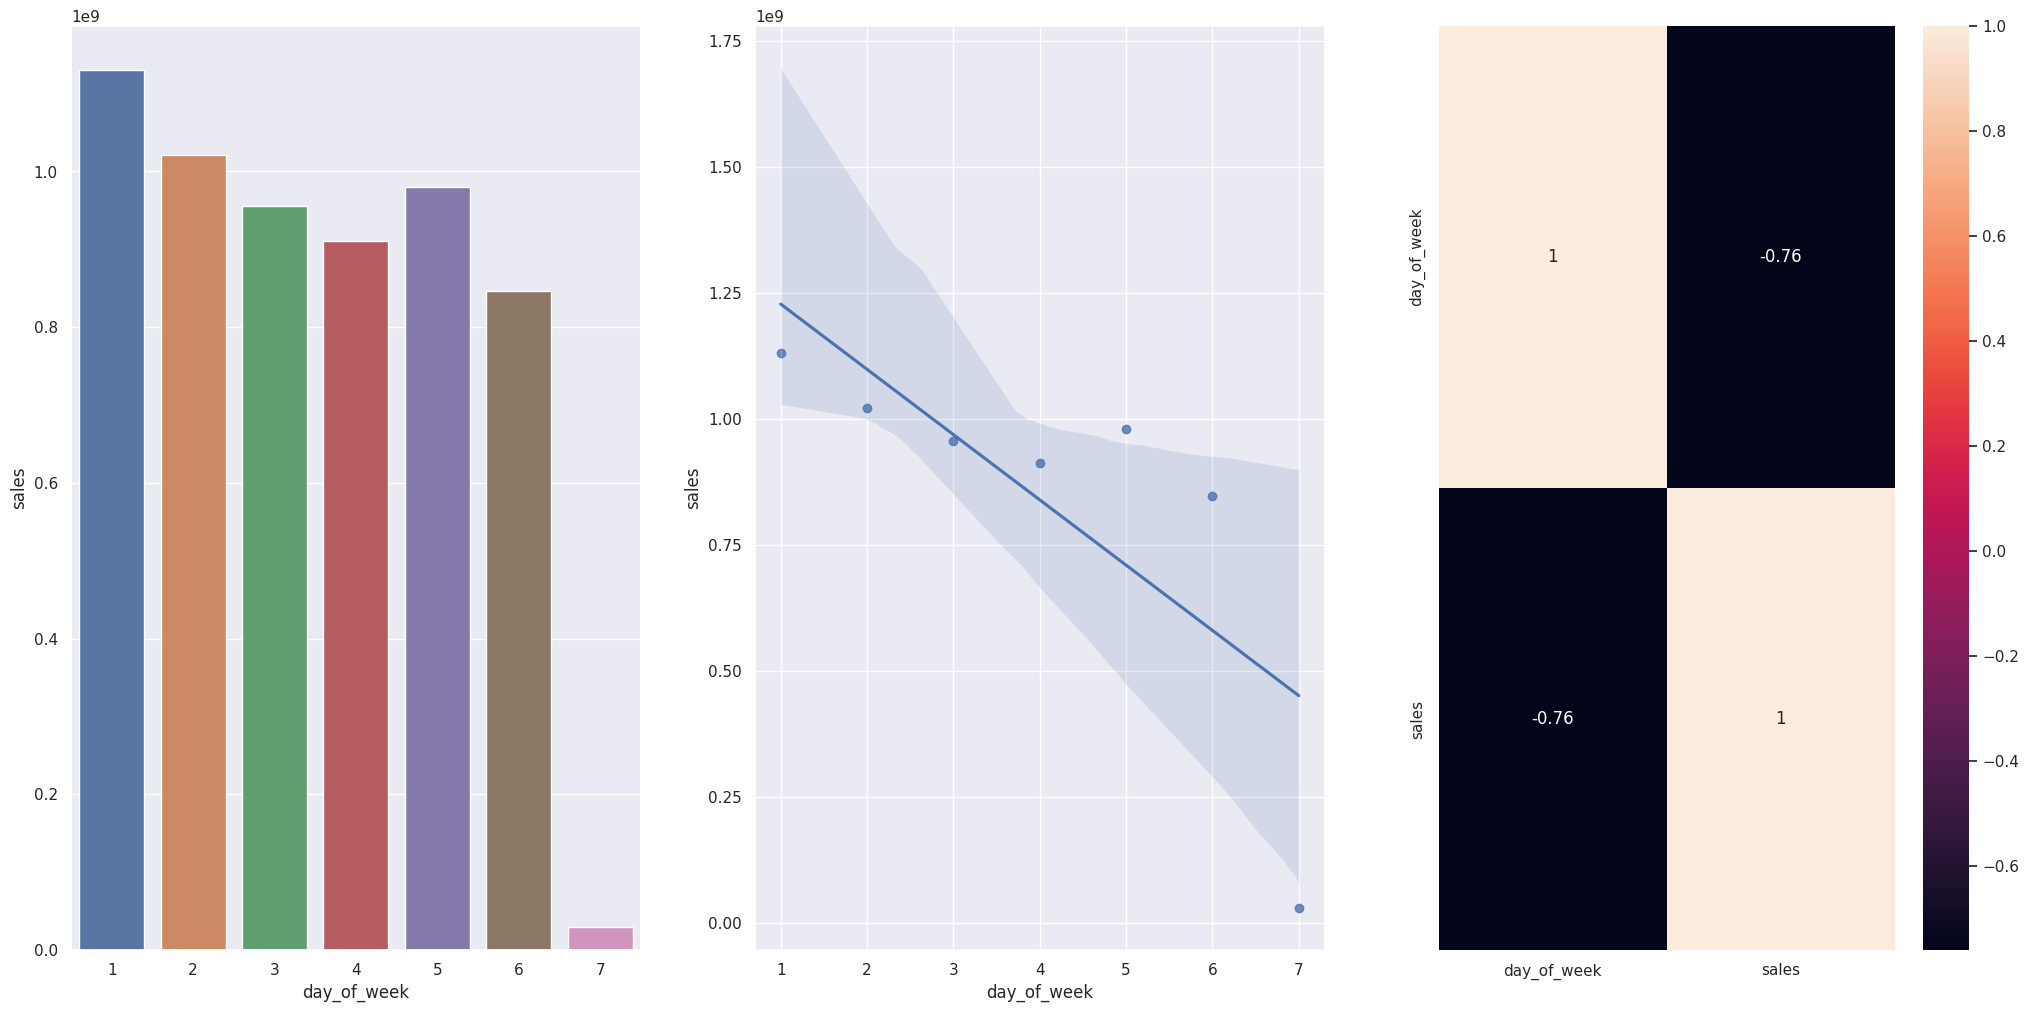

In [58]:
plt.subplot( 1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

H11: Lojas deveriam vender menos durante os feriados escolares.

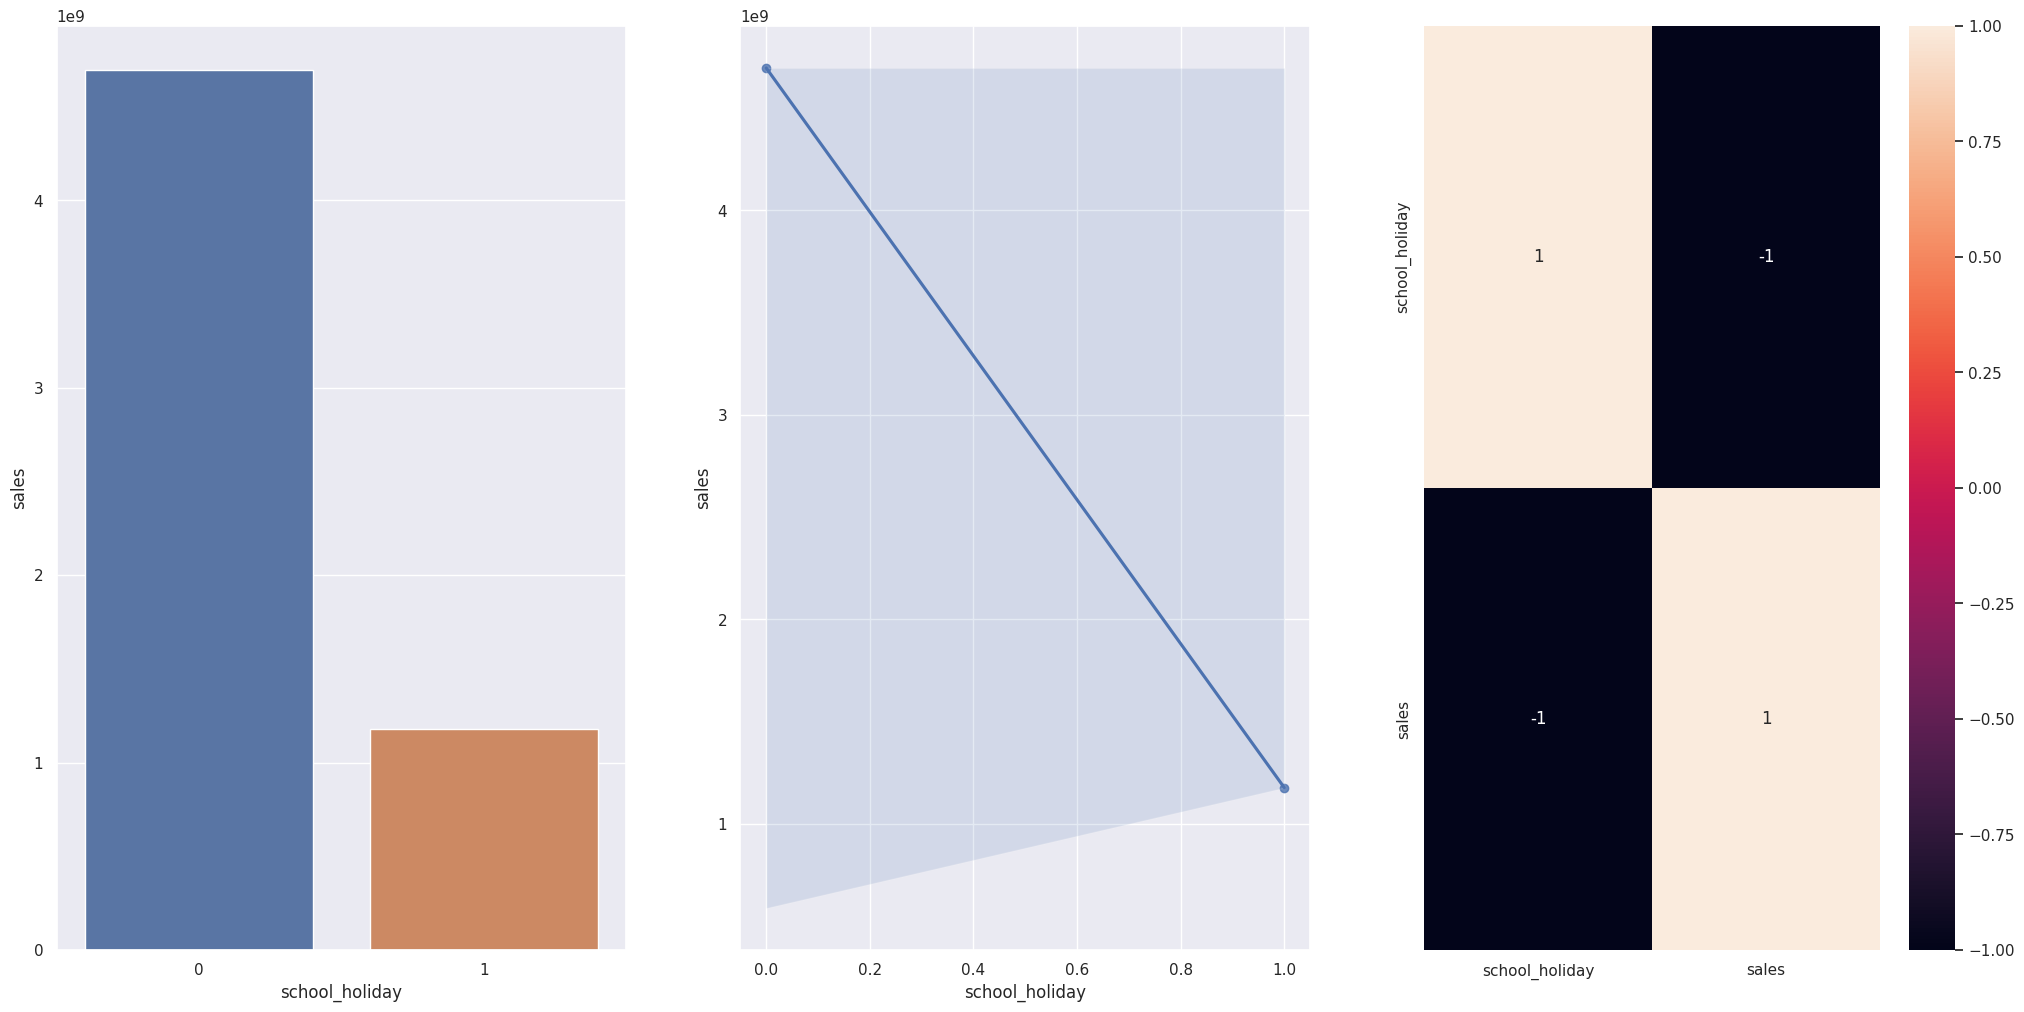

In [59]:
plt.subplot( 1, 3, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 1, 3, 2)
sns.regplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


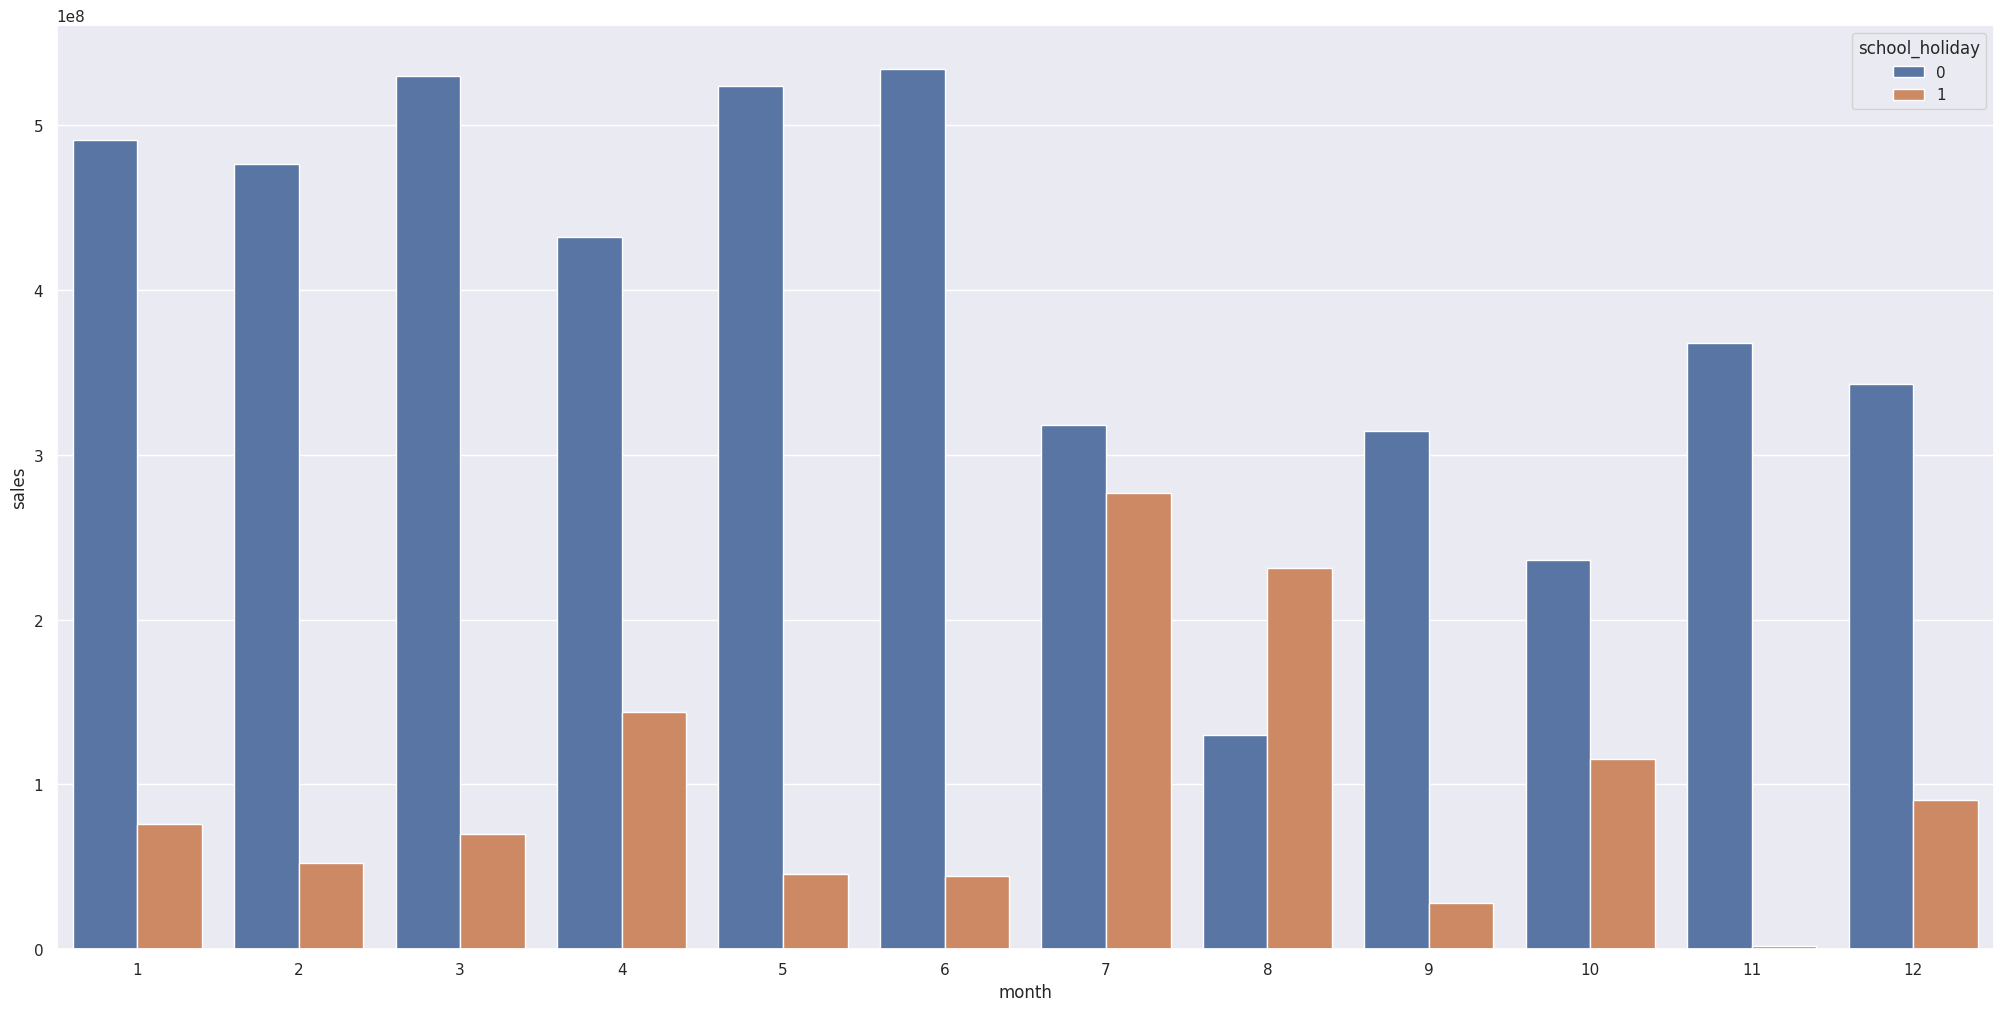

In [60]:
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### 4.2.1. Summary of Hypotheses


In [61]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'FALSA', 'BAIXA'],
       ['H2', 'FALSA', 'MEDIA'],
       ['H3', 'FALSA', 'MEDIA'],
       ['H4', 'FALSA', 'BAIXA'],
       ['H5', 'FALSA', 'BAIXA'],
       ['H6', 'FALSA', 'MEDIA'],
       ['H7', 'FALSA', 'ALTA'],
       ['H8', 'FALSA', 'ALTA'],
       ['H9', 'VERDADEIRA', 'ALTA'],
       ['H10', 'VERDADEIRA', 'ALTA'],
       ['H11', 'VERDADEIRA', 'BAIXA']]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           FALSA        BAIXA
H2           FALSA        MEDIA
H3           FALSA        MEDIA
H4           FALSA        BAIXA
H5           FALSA        BAIXA
H6           FALSA        MEDIA
H7           FALSA        ALTA
H8           FALSA        ALTA
H9           VERDADEIRA   ALTA
H10          VERDADEIRA   ALTA
H11          VERDADEIRA   BAIXA


## 4.3 Multivariate Analysis

### 4.3.1. Numerical Attributes


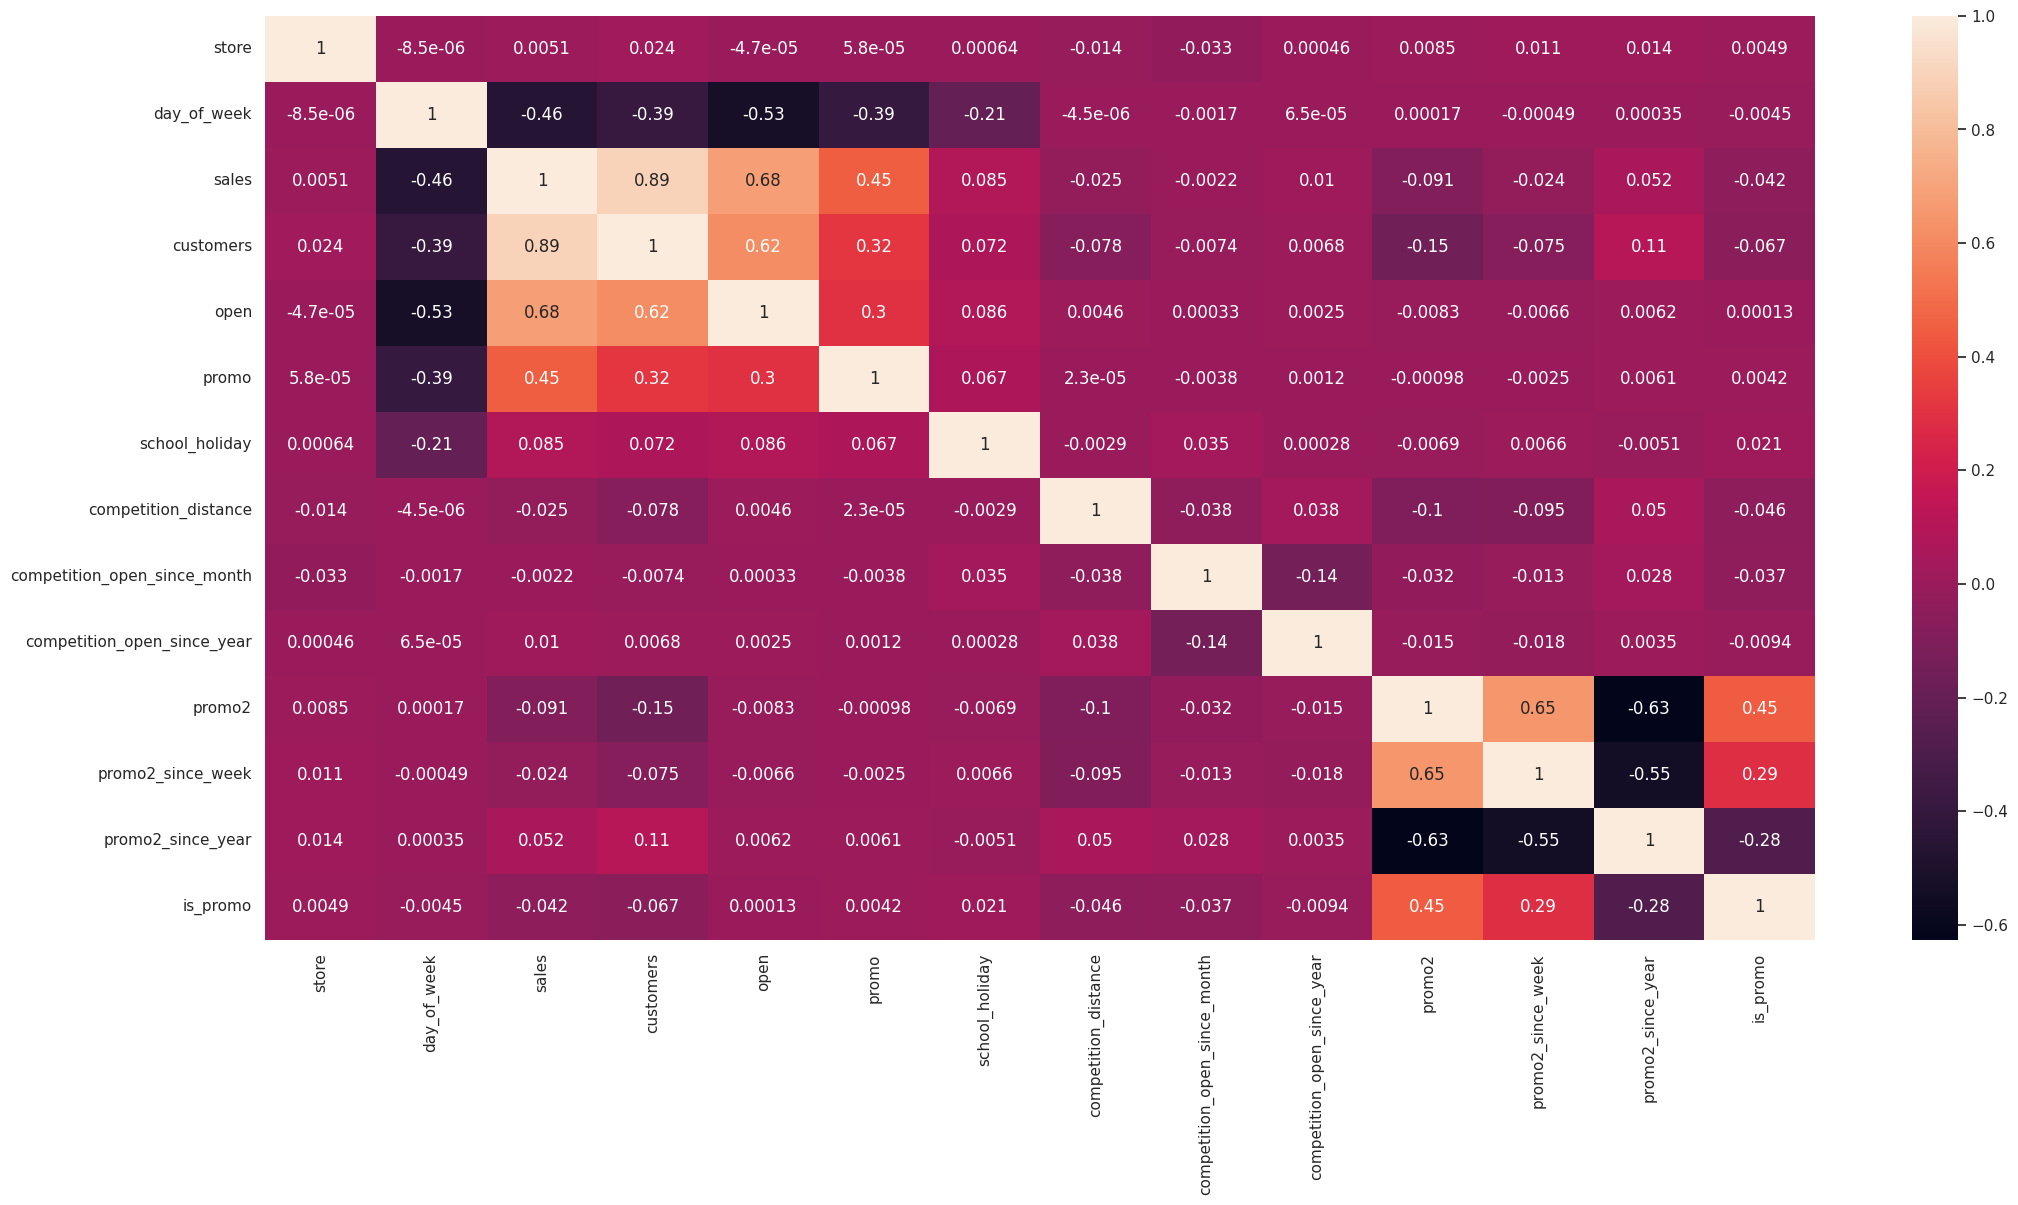

In [62]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes


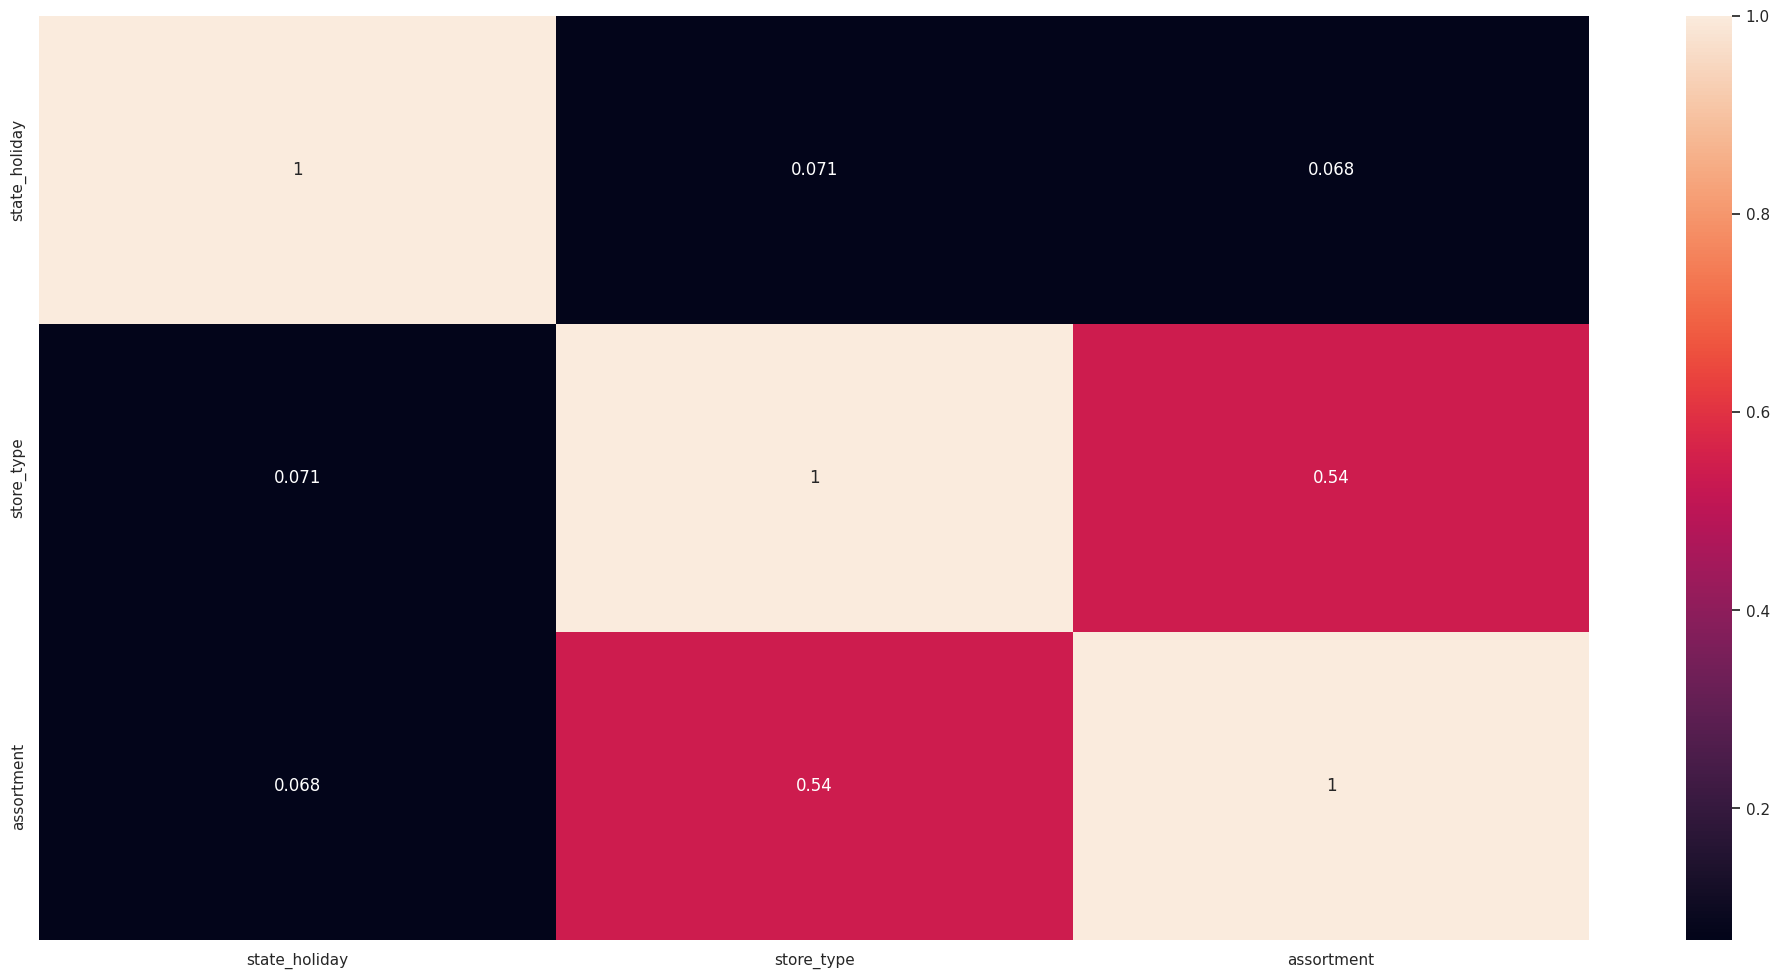

In [63]:
# only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer's v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final data frame
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );



# 5.0 Data Preparation

In [64]:
df5 = df4.copy()


## 5.1 Normalização


## 5.2 Rescaling


In [65]:
a = df4.select_dtypes(include=["int64", "float64"])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,7,2015,0,84,24
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,7,2015,0,71,24
4,5,5,4822,1,1,29910.0,4,2015,0,7,2015,0,4,24


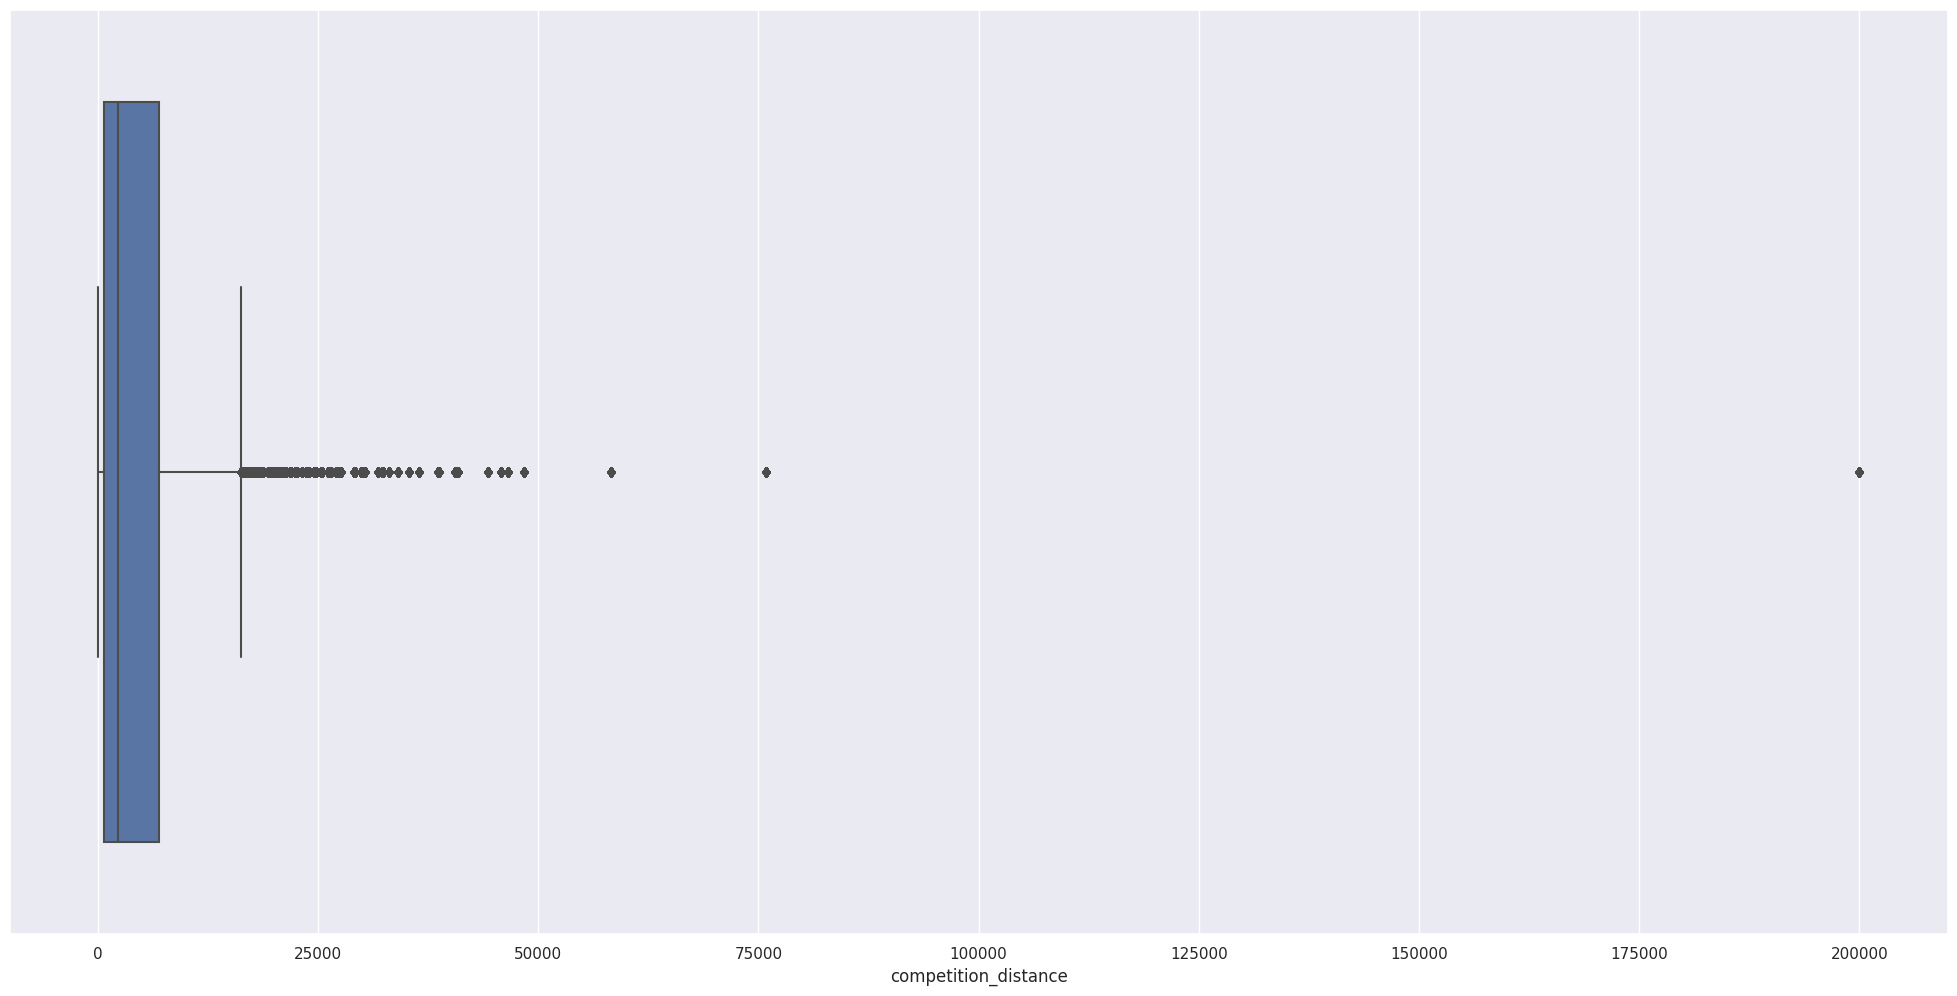

In [66]:
sns.boxplot(x="competition_distance", data=df5);

In [67]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open('parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb' ) )

## 5.3. Transformation


### 5.3.1 Encoding


In [68]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encodinal
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation


In [69]:
# Response Variable Transformation - Log Transformation
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation


In [70]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month 
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


# 6.0. Feature Selection


In [71]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset


In [72]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [73]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [74]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [75]:
df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_chrismas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_date', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

## 6.2. Boruta as Feature Selector


In [76]:
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# # define Boruta
# boruta = BorutaPy( rf, n_estimators=55, verbose=2, random_state=10 ).fit( X_train_n, y_train_n )


In [77]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


In [78]:
cols_selected_boruta = [
    'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos'
]

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modeling


In [79]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]


## 7.1 Average Model


In [80]:


aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance 
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542



## 7.2. Linear Regression Model


In [81]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1871.632253,0.294451,2672.6749



### 7.2.1. Linear Regression Model - Cross Validation


In [82]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Linear Regression,2092.94 +/- 299.58,0.3 +/- 0.02,2961.52 +/- 481.63


## 7.3. Linear Regression Regularized Model - Lasso

In [83]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1894.725095,0.288322,2756.092763


### 7.3.1. Linnear Regression Regularized Model - Lasso - Cross Validation

In [84]:

lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Lasso,2122.84 +/- 364.56,0.29 +/- 0.01,3059.41 +/- 543.84



## 7.4. Random Forest Regressor


In [85]:


# model
rf = RandomForestRegressor( n_estimators=55, n_jobs=-1, random_state=10 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result



,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,673.523304,0.099271,1002.404974



### 7.4.1 Random Forest Regressor - Cross Validation


In [86]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE
0,Random Forest,848.24 +/- 240.46,0.12 +/- 0.03,1267.32 +/- 354.44


## 7.5. XGBoost Regressor


In [87]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=400, 
                              eta=0.01, 
                              max_depth=10,
                              subsample=0.7).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1219.439807,0.178016,1783.965403


### 7.5.1. XGBoost Regressor - Cross validation


In [88]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE
0,XGBoost Regressor,1392.19 +/- 221.31,0.19 +/- 0.02,1998.32 +/- 307.7


## 7.6. Compare Model's Performance


### 7.6.1 Single Performance


In [89]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,673.523304,0.099271,1002.404974
0,XGBoost Regressor,1219.439807,0.178016,1783.965403
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1871.632253,0.294451,2672.674900
0,Linear Regression Lasso,1894.725095,0.288322,2756.092763


### 7.6.2 Real Performance - Cross Validation


In [90]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE' )

,Model Name,MAE CV,MAPE CV,RMSE
0,Random Forest,848.24 +/- 240.46,0.12 +/- 0.03,1267.32 +/- 354.44
0,XGBoost Regressor,1392.19 +/- 221.31,0.19 +/- 0.02,1998.32 +/- 307.7
0,Linear Regression,2092.94 +/- 299.58,0.3 +/- 0.02,2961.52 +/- 481.63
0,Lasso,2122.84 +/- 364.56,0.29 +/- 0.01,3059.41 +/- 543.84



## 8.0. Hyperparameter Fine Tuning


### 8.1. Random Search


In [91]:
warnings.filterwarnings( 'ignore' )

In [92]:
param = {
    'n_estimators':[250, 300],
    'eta':[0.01, 0.02],
    'max_depth':[3, 5],
    'subsample':[0.1, 0.3]
        }
MAX_EVAL = 5


In [93]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
   # choose values for parameters randomly
   hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
   print( hp )
   
   # model
   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'])

   # performance
   result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=True )
   final_result = pd.concat( [final_result, result] )
       
final_result

{'n_estimators': 300, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.3}

KFold Number: 2

KFold Number: 1
{'n_estimators': 250, 'eta': 0.02, 'max_depth': 5, 'subsample': 0.3}

KFold Number: 2

KFold Number: 1
{'n_estimators': 300, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.3}

KFold Number: 2

KFold Number: 1
{'n_estimators': 300, 'eta': 0.02, 'max_depth': 3, 'subsample': 0.1}

KFold Number: 2

KFold Number: 1
{'n_estimators': 250, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.3}

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE
0,XGBoost Regressor,1905.08 +/- 49.95,0.26 +/- 0.0,2777.08 +/- 89.58
0,XGBoost Regressor,1797.46 +/- 44.99,0.24 +/- 0.0,2627.88 +/- 86.63
0,XGBoost Regressor,1905.08 +/- 49.95,0.26 +/- 0.0,2777.08 +/- 89.58
0,XGBoost Regressor,1937.29 +/- 53.01,0.26 +/- 0.0,2818.04 +/- 92.97
0,XGBoost Regressor,1941.39 +/- 52.03,0.26 +/- 0.0,2829.88 +/- 91.76


In [94]:
param_tuned = {
    'n_estimators': 2500,
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.3
        }

In [96]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'] ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,869.699347,0.130351,1260.615788
